# Media Mix Model and Experimental Calibration: A Simulation Study

In this notebook we present a complete simulation study of the media mix model and experimental calibration method presented in the paper ["Media Mix Model Calibration With Bayesian Priors", by Zhang, et al.](https://research.google/pubs/media-mix-model-calibration-with-bayesian-priors/), where the authors propose a convenient parametrization the regression model in terms of the ROAs (return on advertising spend) instead of the classical regression (beta) coefficients. The benefit of this parametrization is that it allows for the use of Bayesian priors on the ROAs, which typically come from previous experiments or domain knowledge. We show, similar as in the autor's paper, that the proposed method is able to provide better ROAs estimation when we have bias on the estimation due to missing covariates or omitted variables. We work out an example of the classical media mix model presented in the paper ["Bayesian Methods for Media Mix Modeling with Carryover and Shape Effects", by Jin, et al.](https://research.google/pubs/bayesian-methods-for-media-mix-modeling-with-carryover-and-shape-effects/). I strongly recommend taking a look in too these two papers before reading this notebook. Reading them in parallel with this notebook is also a good alternative.

For an introduction to the topic I recommend my two previous posts:

- [Media Effect Estimation with Orbit's KTR Model](https://juanitorduz.github.io/orbit_mmm/)
- [Media Effect Estimation with PyMC: Adstock, Saturation & Diminishing Returns](https://juanitorduz.github.io/pymc_mmm/)

and the [`PyMC-Marketing`](https://www.pymc-marketing.io/en/stable/) MMM [example](https://www.pymc-marketing.io/en/stable/notebooks/mmm/mmm_example.html).


## Prepare Notebook

In [1]:
import arviz as az
import graphviz as gr
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import preliz as pz
import pymc as pm
import pytensor.tensor as pt
import seaborn as sns
import xarray as xr
from sklearn import set_config
from sklearn.preprocessing import MaxAbsScaler
from tqdm.notebook import tqdm

set_config(transform_output="pandas")


az.style.use("arviz-darkgrid")
plt.rcParams["figure.figsize"] = [12, 7]
plt.rcParams["figure.dpi"] = 100
plt.rcParams["figure.facecolor"] = "white"


%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = "retina"

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
seed: int = sum(map(ord, "mmm_roas"))
rng: np.random.Generator = np.random.default_rng(seed=seed)

---

## Data Generating Process

We begin by generating a synthetic data set to be able to compare the estimates of various models against the ground truth. We follow a similar strategy as in the [`PyMC-Marketing`](https://www.pymc-marketing.io/en/stable/) MMM [example](https://www.pymc-marketing.io/en/stable/notebooks/mmm/mmm_example.html). However, the main difference is that we add a confounder variable which a causal effect on a specific channel and the target. The following DAG represents the data generating process and the causal dependencies between the variables.

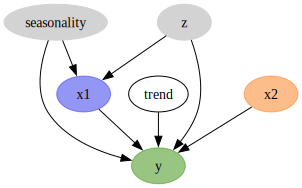

In [3]:
g = gr.Digraph()
g.node(name="seasonality", label="seasonality", color="lightgray", style="filled")
g.node(name="trend", label="trend")
g.node(name="z", label="z", color="lightgray", style="filled")
g.node(name="x1", label="x1", color="#2a2eec80", style="filled")
g.node(name="x2", label="x2", color="#fa7c1780", style="filled")
g.node(name="y", label="y", color="#328c0680", style="filled")
g.edge(tail_name="seasonality", head_name="x1")
g.edge(tail_name="z", head_name="x1")
g.edge(tail_name="x1", head_name="y")
g.edge(tail_name="seasonality", head_name="y")
g.edge(tail_name="trend", head_name="y")
g.edge(tail_name="z", head_name="y")
g.edge(tail_name="x2", head_name="y")
g  # noqa: B018

Here $x_1$ and $x_2$ represent two media channels and $y$ our target variable (e.g. sales). The confounder $z$ has a causal effect on $x_1$ and $y$.

**Remark:** If you are a color geek like me, you can get the color pallette color codes of the `arviz` theme [here](# https://github.com/arviz-devs/arviz/blob/main/arviz/plots/styles/arviz-darkgrid.mplstyle). Note that you can add them with transparency as described [here](# https://graphviz.org/Gallery/neato/transparency.html). Note that the transparency is specified by the las two characters of the hex code.

We not proceed to generate weekly data for $2.5$ years. In the following snippet of code we generate the date range, seasonality and trend components and, the covariate $z$, which is always positive.

In [4]:
# date range
min_date = pd.to_datetime("2021-10-02")
max_date = pd.to_datetime("2024-03-30")

data_df = pd.DataFrame(
    data={"date": pd.date_range(start=min_date, end=max_date, freq="W-SAT")}
)

n = data_df.shape[0]

data_df["dayofyear"] = data_df["date"].dt.dayofyear
data_df["quarter"] = data_df["date"].dt.to_period("Q").dt.strftime("%YQ%q")
data_df["trend"] = (np.linspace(start=0.0, stop=50, num=n) + 10) ** (1 / 3) - 1
data_df["cs"] = -np.sin(2 * 2 * np.pi * data_df["dayofyear"] / 365.25)
data_df["cc"] = np.cos(1 * 2 * np.pi * data_df["dayofyear"] / 365.25)
data_df["seasonality"] = 0.3 * (data_df["cs"] + data_df["cc"])
data_df["z"] = 0.3 * rng.gamma(shape=1, scale=2 / 3, size=n)

The following plot shows the time series development of these features (and the aggregation).

Text(0.5, 0.98, 'Data Components')

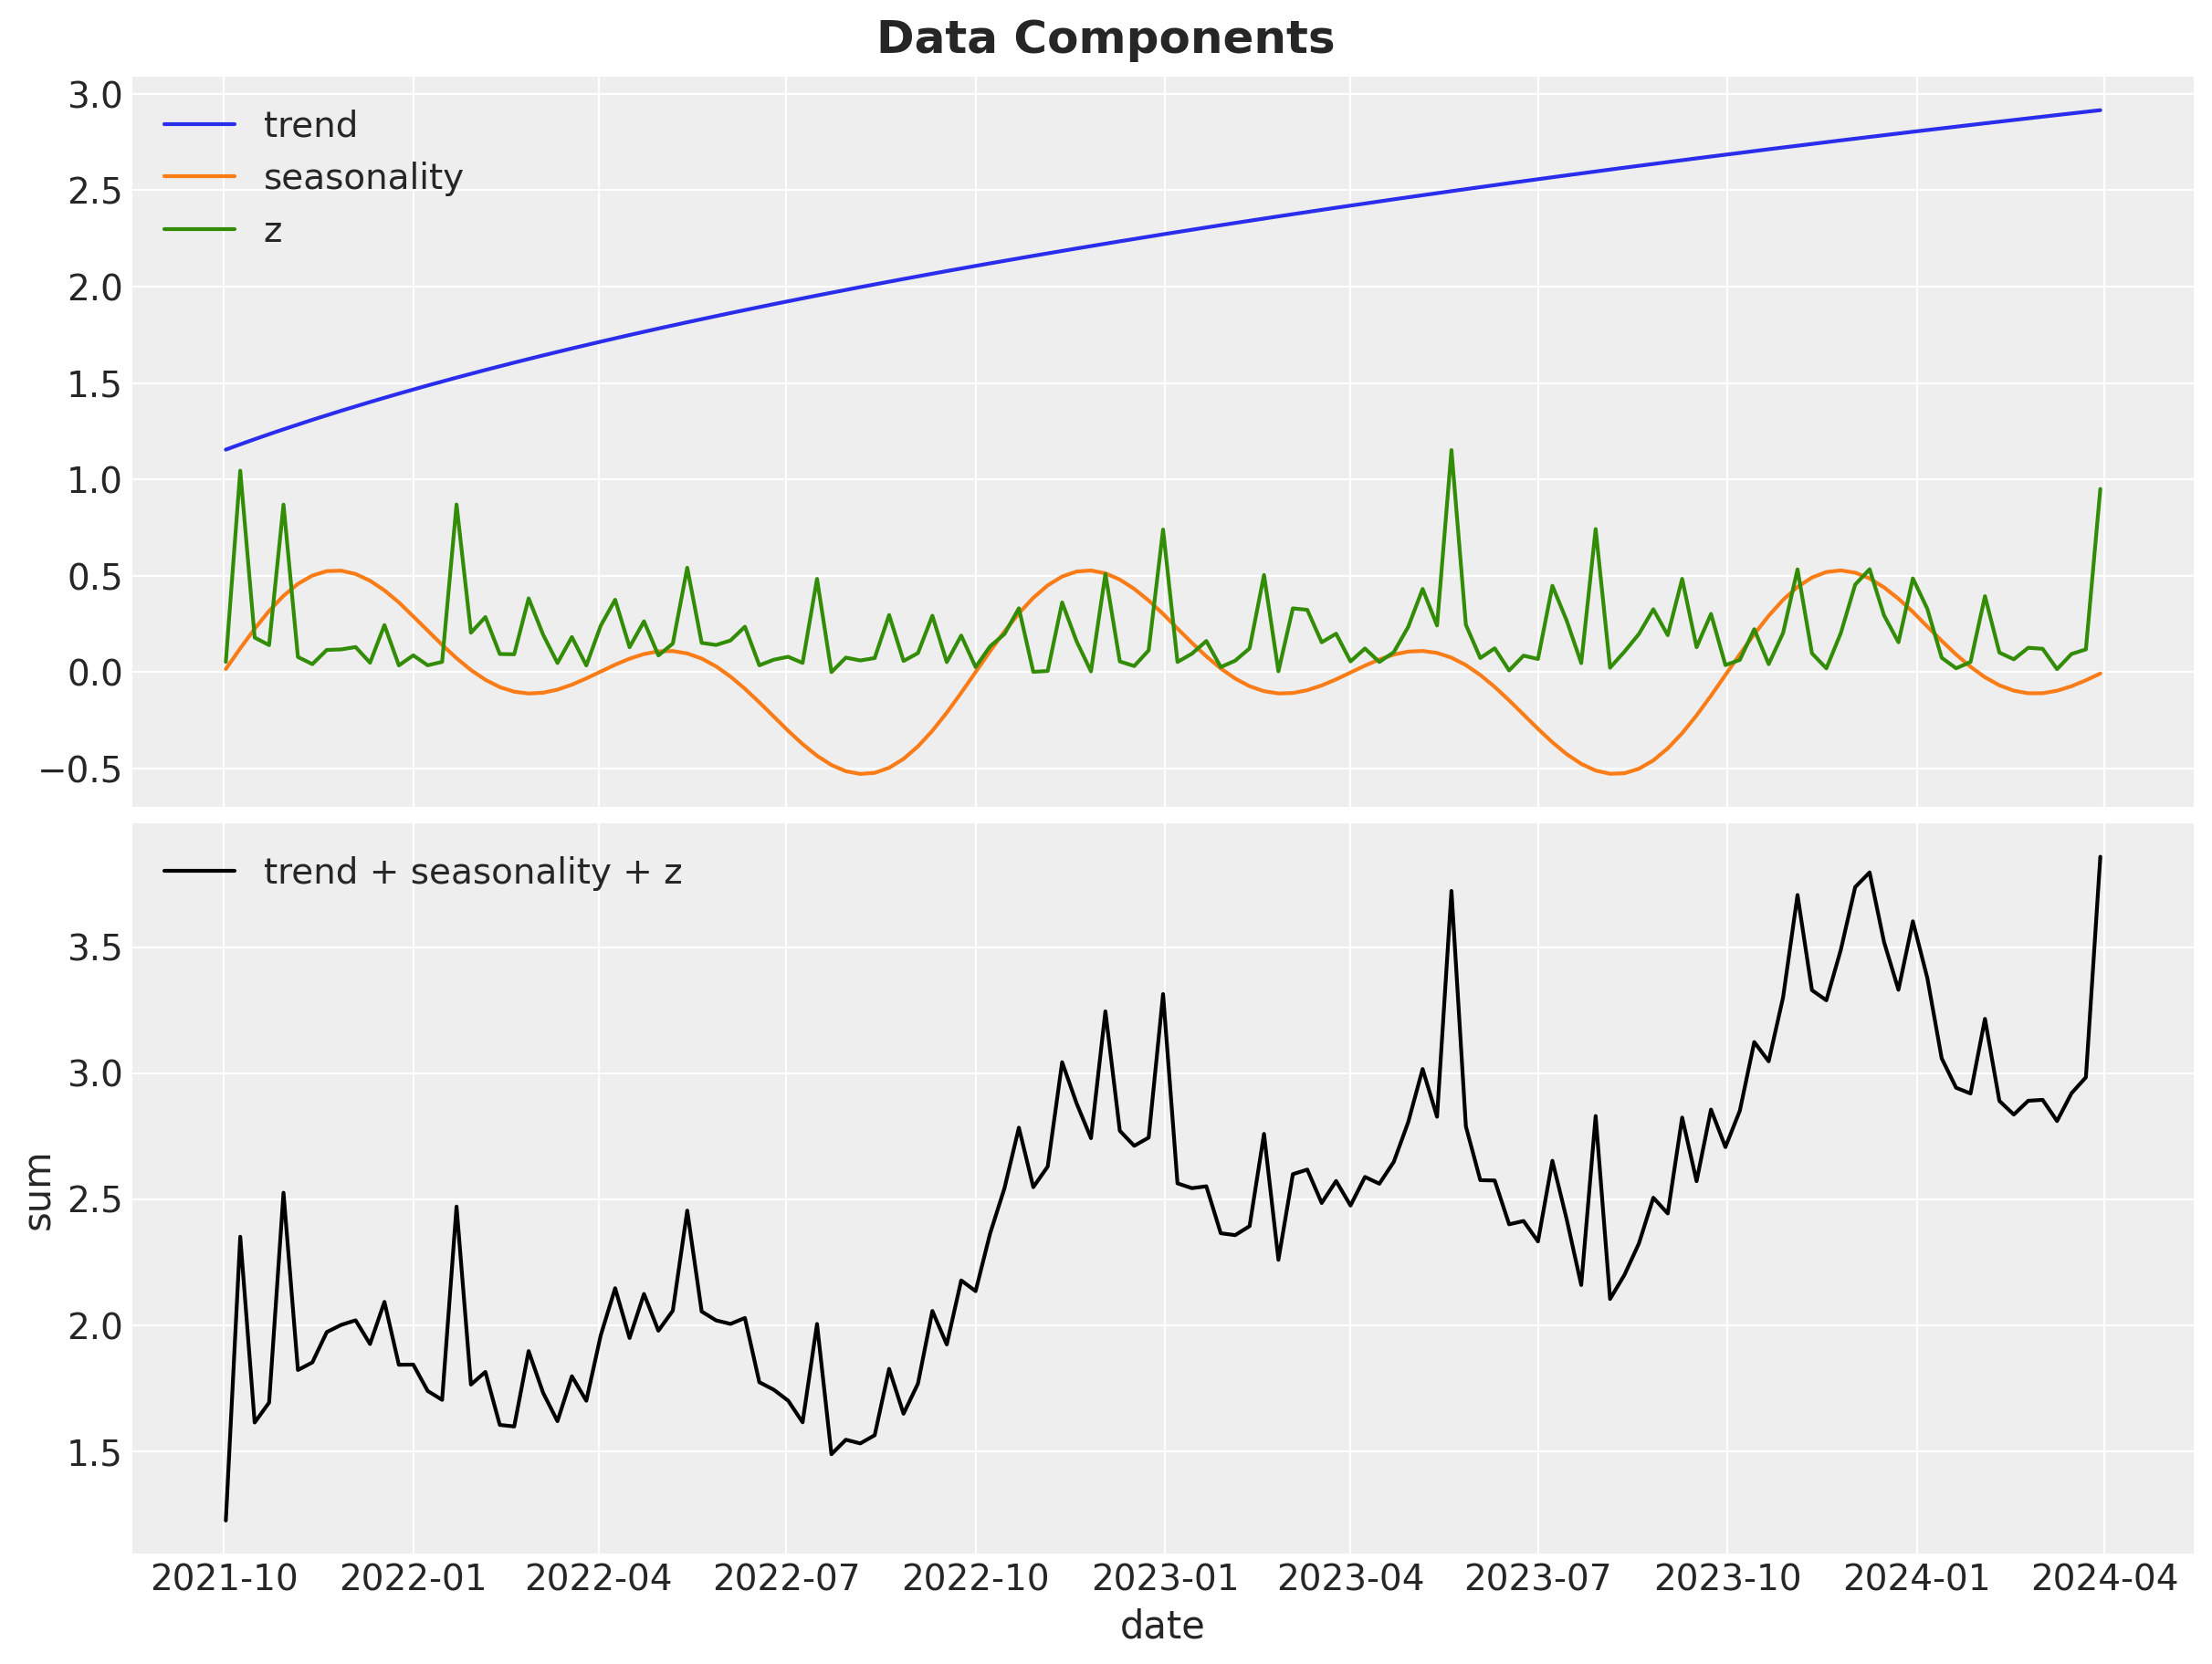

In [5]:
fig, ax = plt.subplots(
    nrows=2,
    ncols=1,
    figsize=(12, 9),
    sharex=True,
    sharey=False,
    layout="constrained",
)
sns.lineplot(
    data=data_df,
    x="date",
    y="trend",
    color="C0",
    label="trend",
    ax=ax[0],
)
sns.lineplot(
    data=data_df,
    x="date",
    y="seasonality",
    color="C1",
    label="seasonality",
    ax=ax[0],
)
sns.lineplot(data=data_df, x="date", y="z", color="C2", label="z", ax=ax[0])
ax[0].legend(loc="upper left")
ax[0].set(xlabel="date", ylabel=None)

sns.lineplot(
    data=data_df.eval("sum = trend + seasonality + z"),
    x="date",
    y="sum",
    color="black",
    label="trend + seasonality + z",
    ax=ax[1],
)
ax[1].legend(loc="upper left")

fig.suptitle(t="Data Components", fontsize=18, fontweight="bold")

Next, we generate the media channels $x_1$ and $x_2$. Note that the channel spend $x_1$ depends both the seasonality component and the $z$ variable. We also generate Gaussian noise to be added to the target variable $y$.

In [6]:
data_df["x1"] = 1.2 * (
    0.5
    + 0.4 * data_df["seasonality"]
    + 0.6 * data_df["z"]
    + 0.1 * rng.poisson(lam=1 / 2, size=n)
)

data_df["x2"] = 0.3 * rng.gamma(shape=1, scale=1, size=n)

data_df["epsilon"] = rng.normal(loc=0, scale=0.1, size=n)

We now can visualize all the components:

Text(0.5, 0.98, 'Data Components')

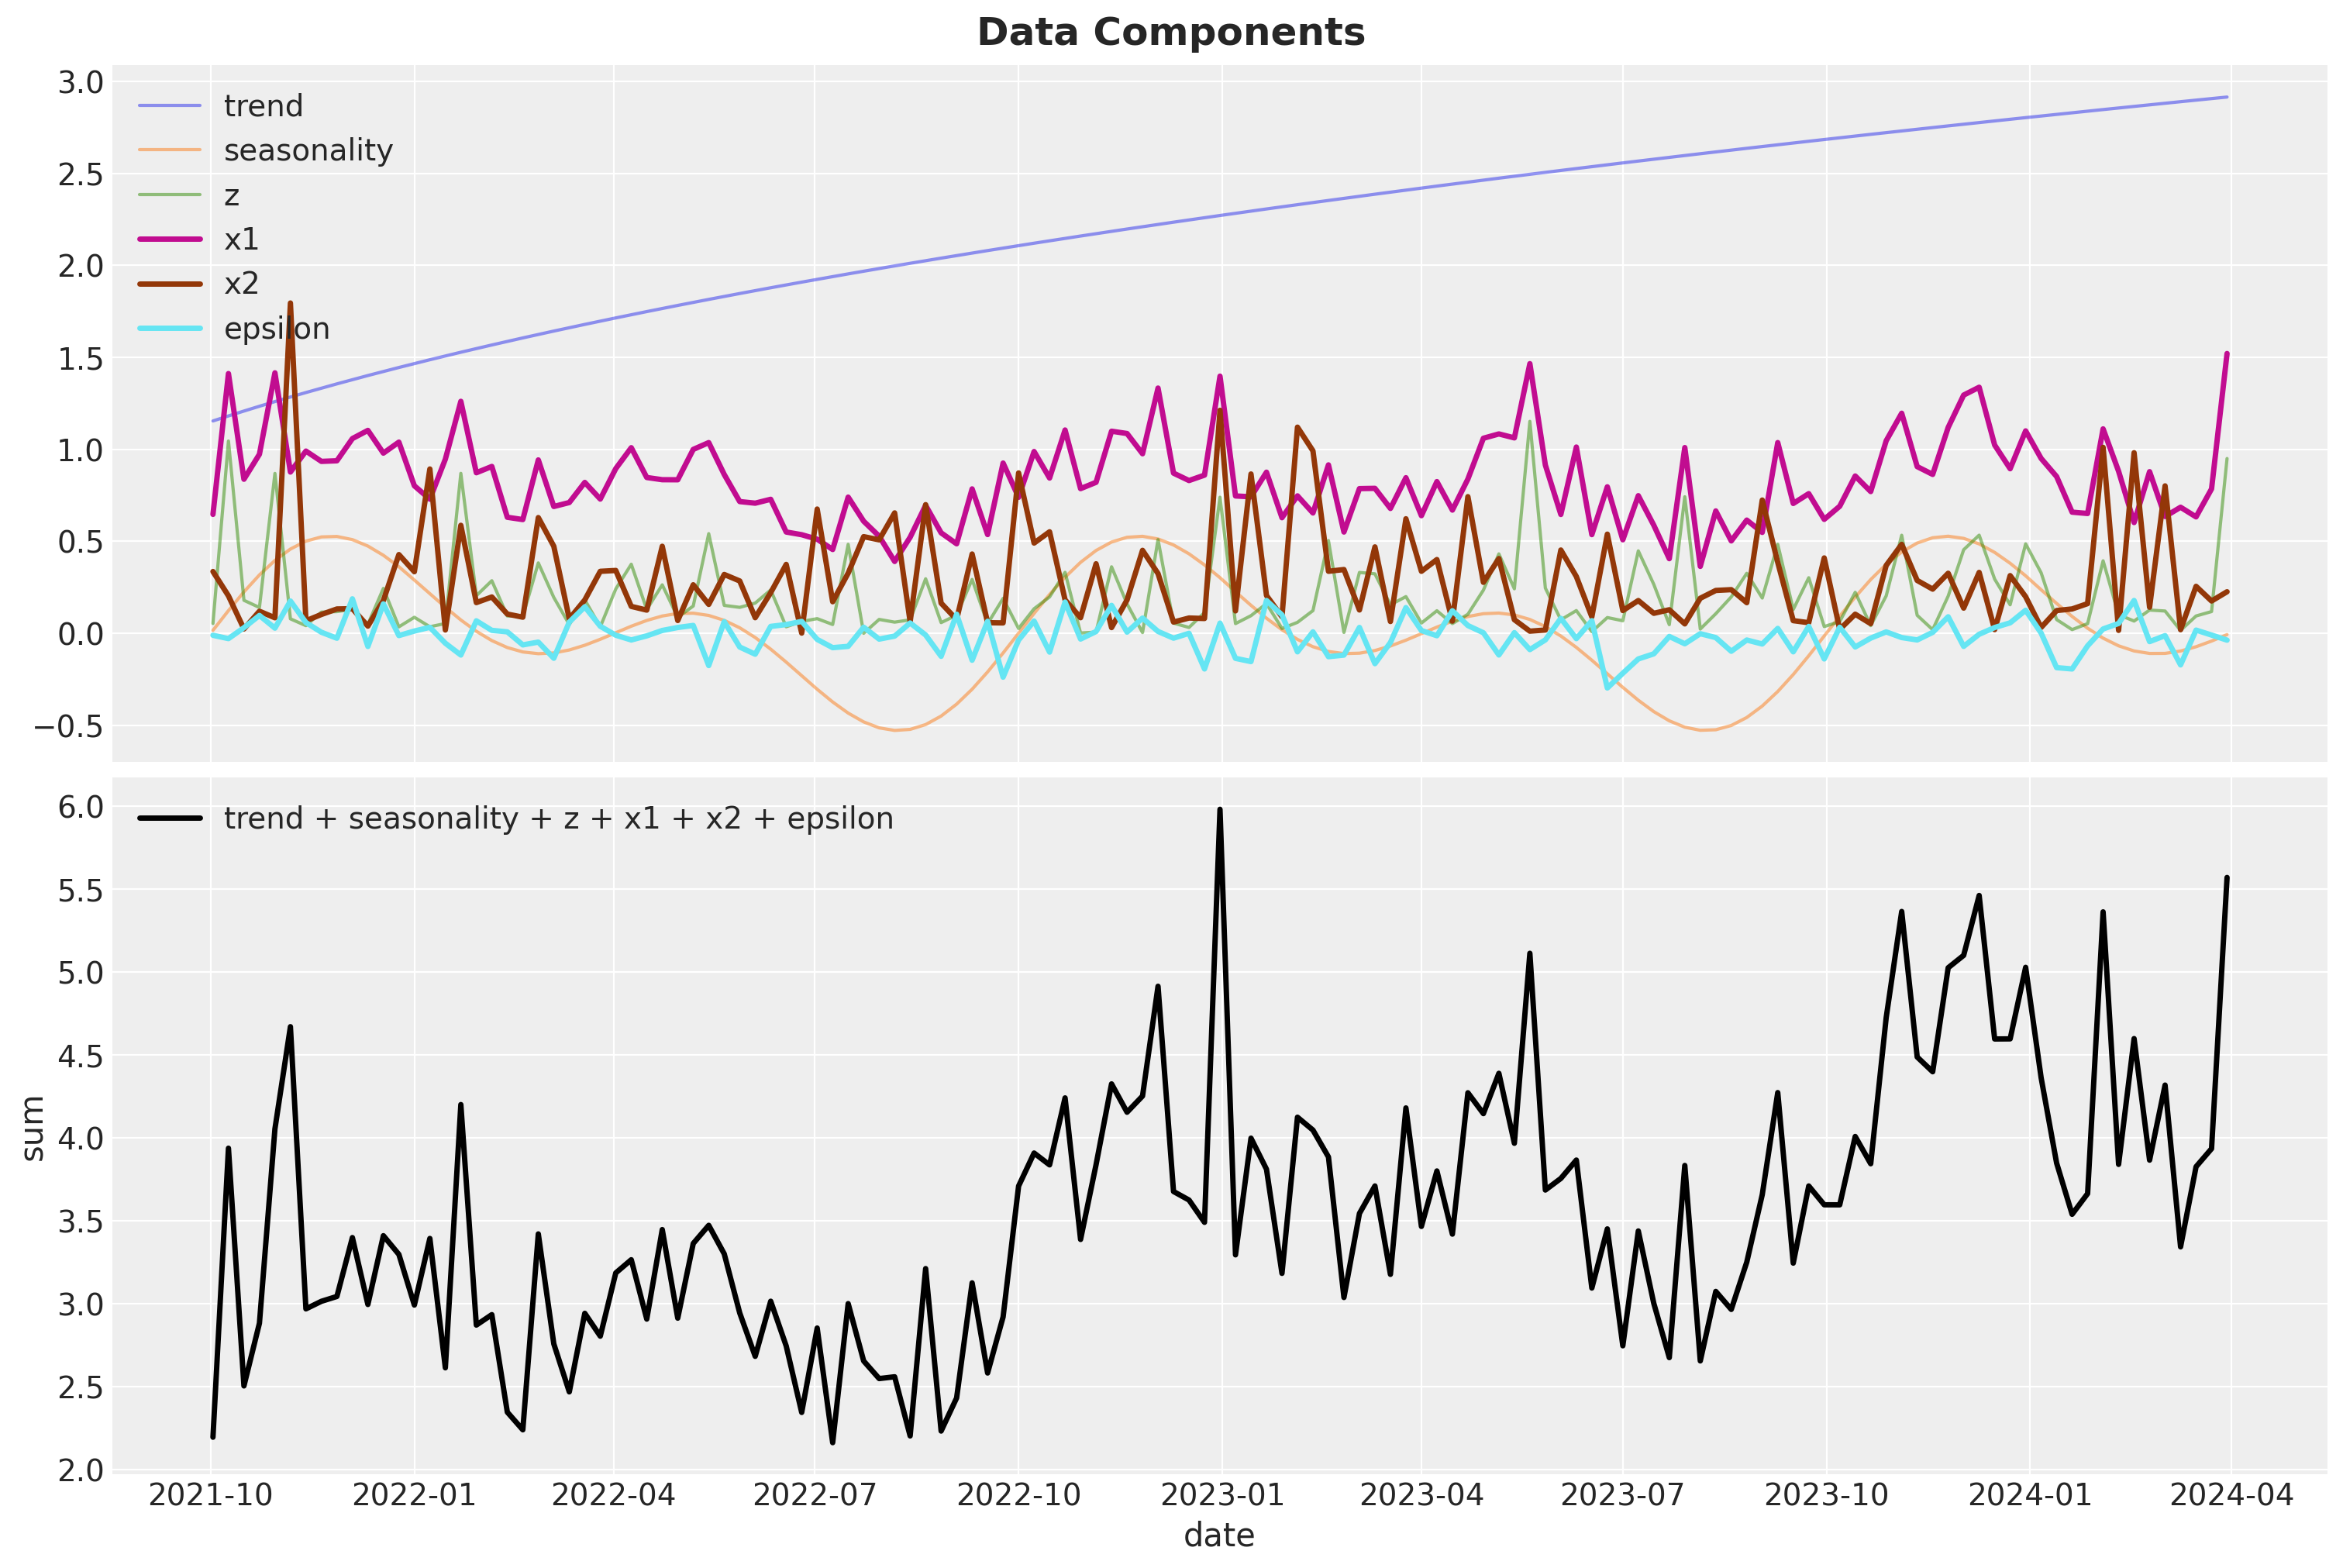

In [7]:
fig, ax = plt.subplots(
    nrows=2,
    ncols=1,
    figsize=(15, 10),
    sharex=True,
    sharey=False,
    layout="constrained",
)
sns.lineplot(
    data=data_df,
    x="date",
    y="trend",
    color="C0",
    alpha=0.5,
    label="trend",
    ax=ax[0],
)
sns.lineplot(
    data=data_df,
    x="date",
    y="seasonality",
    color="C1",
    alpha=0.5,
    label="seasonality",
    ax=ax[0],
)
sns.lineplot(data=data_df, x="date", y="z", color="C2", alpha=0.5, label="z", ax=ax[0])
sns.lineplot(
    data=data_df, x="date", y="x1", color="C3", linewidth=2.5, label="x1", ax=ax[0]
)
sns.lineplot(
    data=data_df, x="date", y="x2", color="C4", linewidth=2.5, label="x2", ax=ax[0]
)
sns.lineplot(
    data=data_df,
    x="date",
    y="epsilon",
    color="C5",
    linewidth=2.5,
    label="epsilon",
    ax=ax[0],
)
ax[0].legend(loc="upper left")
ax[0].set(xlabel="date", ylabel=None)

sns.lineplot(
    data=data_df.eval("sum = trend + seasonality + z + x1 + x2 + epsilon"),
    x="date",
    y="sum",
    color="black",
    linewidth=2.5,
    label="trend + seasonality + z + x1 + x2 + epsilon",
    ax=ax[1],
)
ax[1].legend(loc="upper left")

fig.suptitle(t="Data Components", fontsize=18, fontweight="bold")

Note that we have not yet added the non-linear effects of the media channels. This is a key component in media mix models as we expect that the media signal to have carryover (adstock) and saturation effects (for a detailed description of these transformation and alternative parametrizations see the paper ["Bayesian Methods for Media Mix Modeling with Carryover and Shape Effects", by Jin, et al.](https://research.google/pubs/bayesian-methods-for-media-mix-modeling-with-carryover-and-shape-effects/)).  We add these two transformations using some helper functions (the code is not that important):

In [8]:
def geometric_adstock(x, alpha, l_max, normalize):
    """Vectorized geometric adstock transformation."""
    cycles = [
        pt.concatenate(tensor_list=[pt.zeros(shape=x.shape)[:i], x[: x.shape[0] - i]])
        for i in range(l_max)
    ]
    x_cycle = pt.stack(cycles)
    x_cycle = pt.transpose(x=x_cycle, axes=[1, 2, 0])
    w = pt.as_tensor_variable([pt.power(alpha, i) for i in range(l_max)])
    w = pt.transpose(w)[None, ...]
    w = w / pt.sum(w, axis=2, keepdims=True) if normalize else w
    return pt.sum(pt.mul(x_cycle, w), axis=2)


def logistic_saturation(x, lam):
    """Logistic saturation transformation."""
    return (1 - pt.exp(-lam * x)) / (1 + pt.exp(-lam * x))

First, we apply the adstock transformation. The strength of the carryover effect is controlled by the decay parameter $0\leq \alpha \leq 1$.

In [9]:
# adstock maximum lag
l_max = 4
# apply geometric adstock transformation
alpha1 = 0.3
alpha2 = 0.5

alpha = np.array([alpha1, alpha2])

data_df[["x1_adstock", "x2_adstock"]] = geometric_adstock(
    x=data_df[["x1", "x2"]], alpha=alpha, l_max=l_max, normalize=True
).eval()

Let's visualize the raw and transformed data:

Text(0.5, 0.98, 'Adstock Transformation')

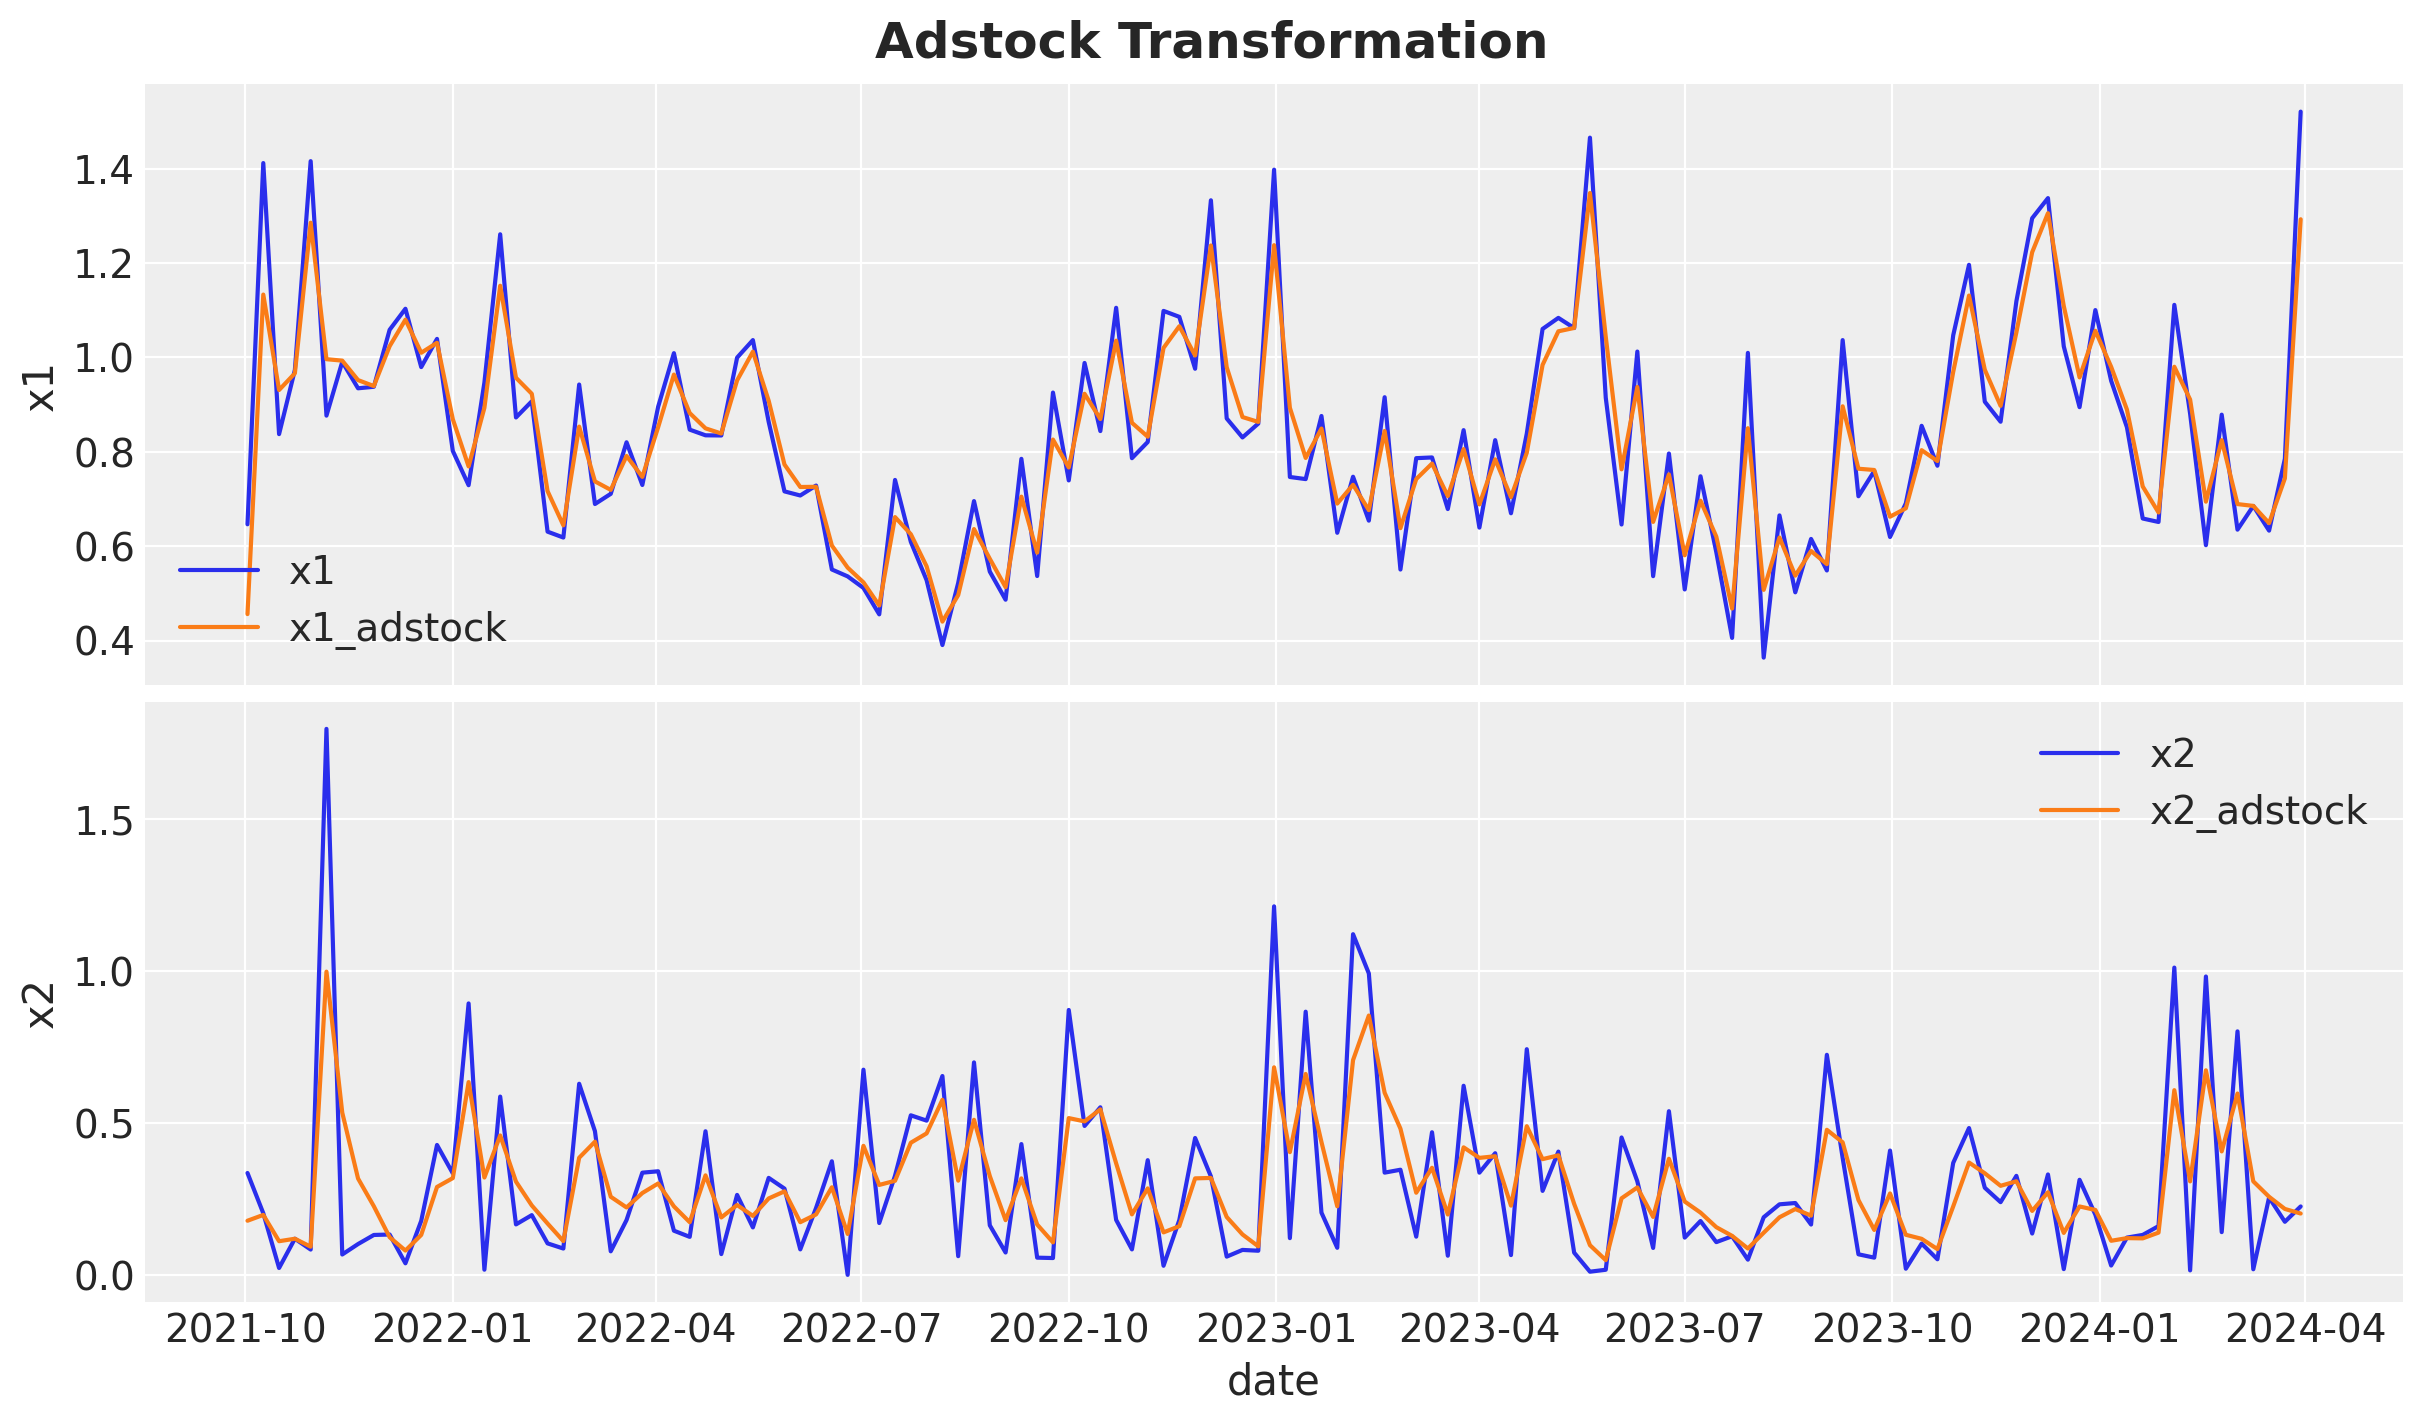

In [10]:
fig, ax = plt.subplots(
    nrows=2, ncols=1, figsize=(12, 7), sharex=True, sharey=False, layout="constrained"
)
sns.lineplot(x="date", y="x1", data=data_df, color="C0", label="x1", ax=ax[0])
sns.lineplot(
    x="date",
    y="x1_adstock",
    data=data_df,
    color="C1",
    label="x1_adstock",
    ax=ax[0],
)
sns.lineplot(x="date", y="x2", data=data_df, color="C0", label="x2", ax=ax[1])
sns.lineplot(
    x="date",
    y="x2_adstock",
    data=data_df,
    color="C1",
    label="x2_adstock",
    ax=ax[1],
)

fig.suptitle("Adstock Transformation", fontsize=18, fontweight="bold")

Observe that the adstock transformation has the effect of smoothing the media signal.

We continue by applying the saturation transformation:

In [11]:
# apply saturation transformation
lam1 = 1.0
lam2 = 2.5

lam = np.array([lam1, lam2])

data_df[["x1_adstock_saturated", "x2_adstock_saturated"]] = logistic_saturation(
    x=data_df[["x1_adstock", "x2_adstock"]], lam=lam
).eval()

This transformation simply compresses peaks. Let;s first visualize the saturation function (which depends on a parameter $\lambda > 0$).

Text(0.5, 1.0, 'Saturation Transformation')

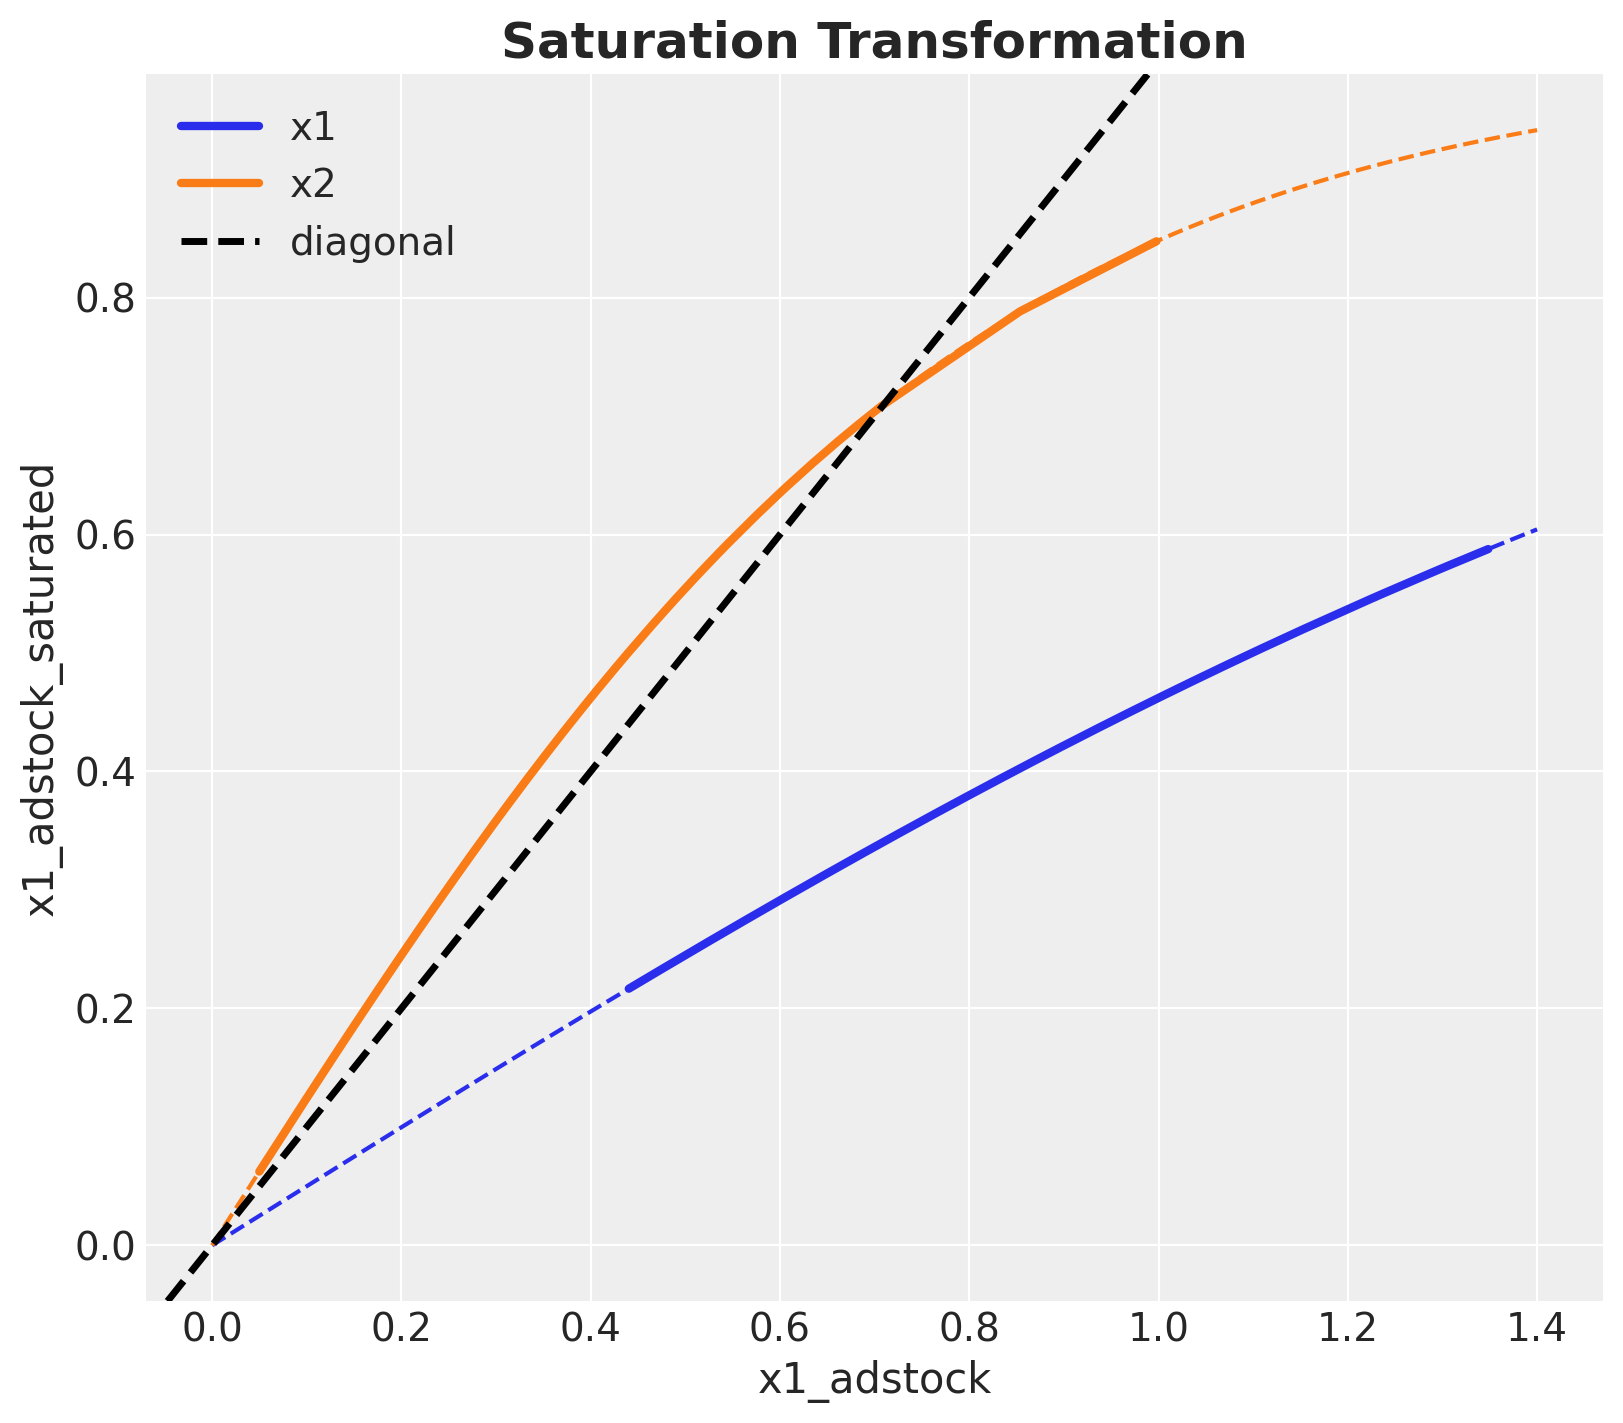

In [12]:
x_range = np.linspace(start=0, stop=1.4, num=100)

fig, ax = plt.subplots(figsize=(8, 7))
sns.lineplot(
    data=data_df,
    x="x1_adstock",
    y="x1_adstock_saturated",
    linewidth=3,
    label="x1",
    ax=ax,
)
sns.lineplot(
    x=x_range,
    y=logistic_saturation(x=x_range, lam=lam1).eval(),
    color="C0",
    linestyle="--",
    ax=ax,
)
sns.lineplot(
    data=data_df,
    x="x2_adstock",
    y="x2_adstock_saturated",
    linewidth=3,
    label="x2",
    ax=ax,
)
sns.lineplot(
    x=x_range,
    y=logistic_saturation(x=x_range, lam=lam2).eval(),
    color="C1",
    linestyle="--",
    ax=ax,
)
ax.axline(
    (0, 0), slope=1, color="black", linestyle="--", linewidth=2.5, label="diagonal"
)
ax.legend(loc="upper left")
ax.set_title("Saturation Transformation", fontsize=18, fontweight="bold")

We can now compare the initial signal and how is transformed by these two  on-linear transformations:

/var/folders/xv/983bz0q51wbb27tjz2c4r40w0000gn/T/ipykernel_4063/149485743.py:10: UserWarning: This figure was using a layout engine that is incompatible with subplots_adjust and/or tight_layout; not calling subplots_adjust.
  fig.autofmt_xdate()


Text(0.5, 0.98, 'Media Costs Data - Transformed')

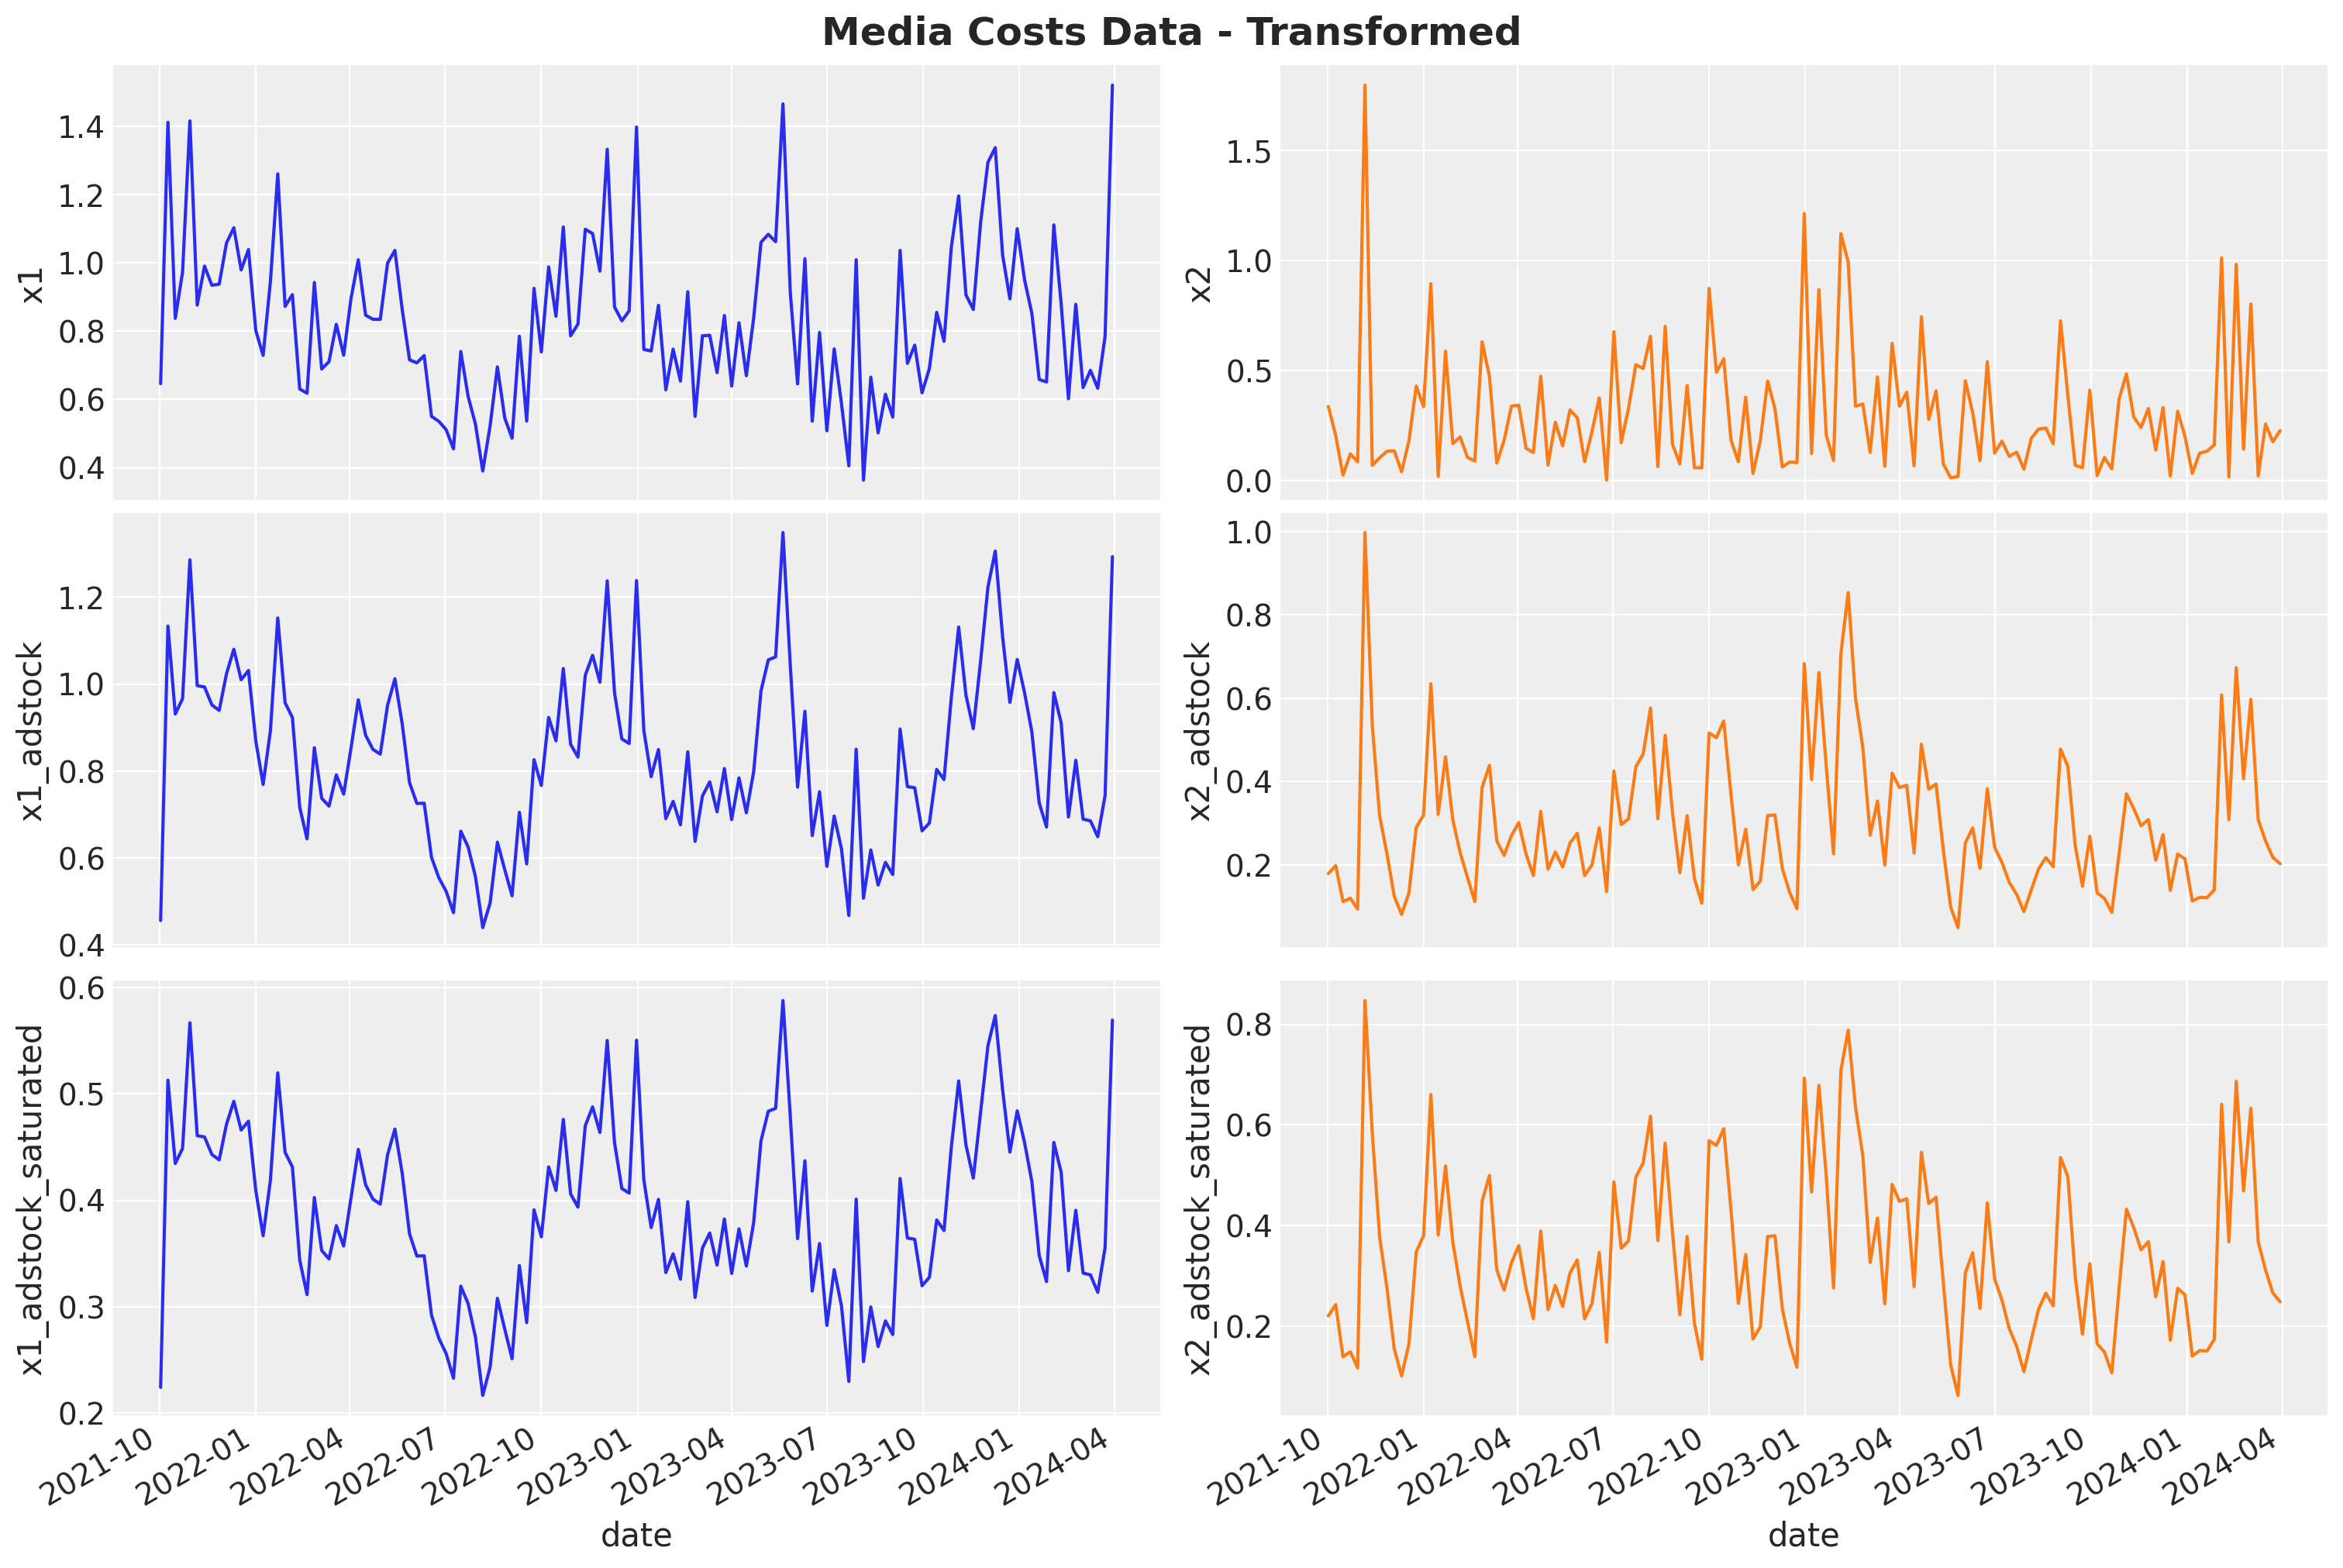

In [13]:
fig, ax = plt.subplots(
    nrows=3, ncols=2, figsize=(15, 10), sharex=True, sharey=False, layout="constrained"
)
sns.lineplot(x="date", y="x1", data=data_df, color="C0", ax=ax[0, 0])
sns.lineplot(x="date", y="x2", data=data_df, color="C1", ax=ax[0, 1])
sns.lineplot(x="date", y="x1_adstock", data=data_df, color="C0", ax=ax[1, 0])
sns.lineplot(x="date", y="x2_adstock", data=data_df, color="C1", ax=ax[1, 1])
sns.lineplot(x="date", y="x1_adstock_saturated", data=data_df, color="C0", ax=ax[2, 0])
sns.lineplot(x="date", y="x2_adstock_saturated", data=data_df, color="C1", ax=ax[2, 1])
fig.autofmt_xdate()
fig.suptitle("Media Costs Data - Transformed", fontsize=18, fontweight="bold")

Now we are ready to put everything together and generate the target variable $y$. We just need to apply some weights $\beta$ to the transformed media data (i.e. specifying the regression coefficients).

In [14]:
beta1 = 2.0
beta2 = 1.5
amplitude = 100

data_df = data_df.eval(
    f"""
    x1_effect = {beta1} * x1_adstock_saturated
    x2_effect = {beta2} * x2_adstock_saturated
    y = {amplitude} * (trend + seasonality + z + x1_effect + x2_effect + epsilon)
    y01 = {amplitude} * (trend + seasonality + z + x2_effect + epsilon)
    y02 = {amplitude} * (trend + seasonality + z + x1_effect + epsilon)
    """
)

Finally, we can see the components and the final target variable: 

Text(0.5, 0.98, 'Data Generating Process')

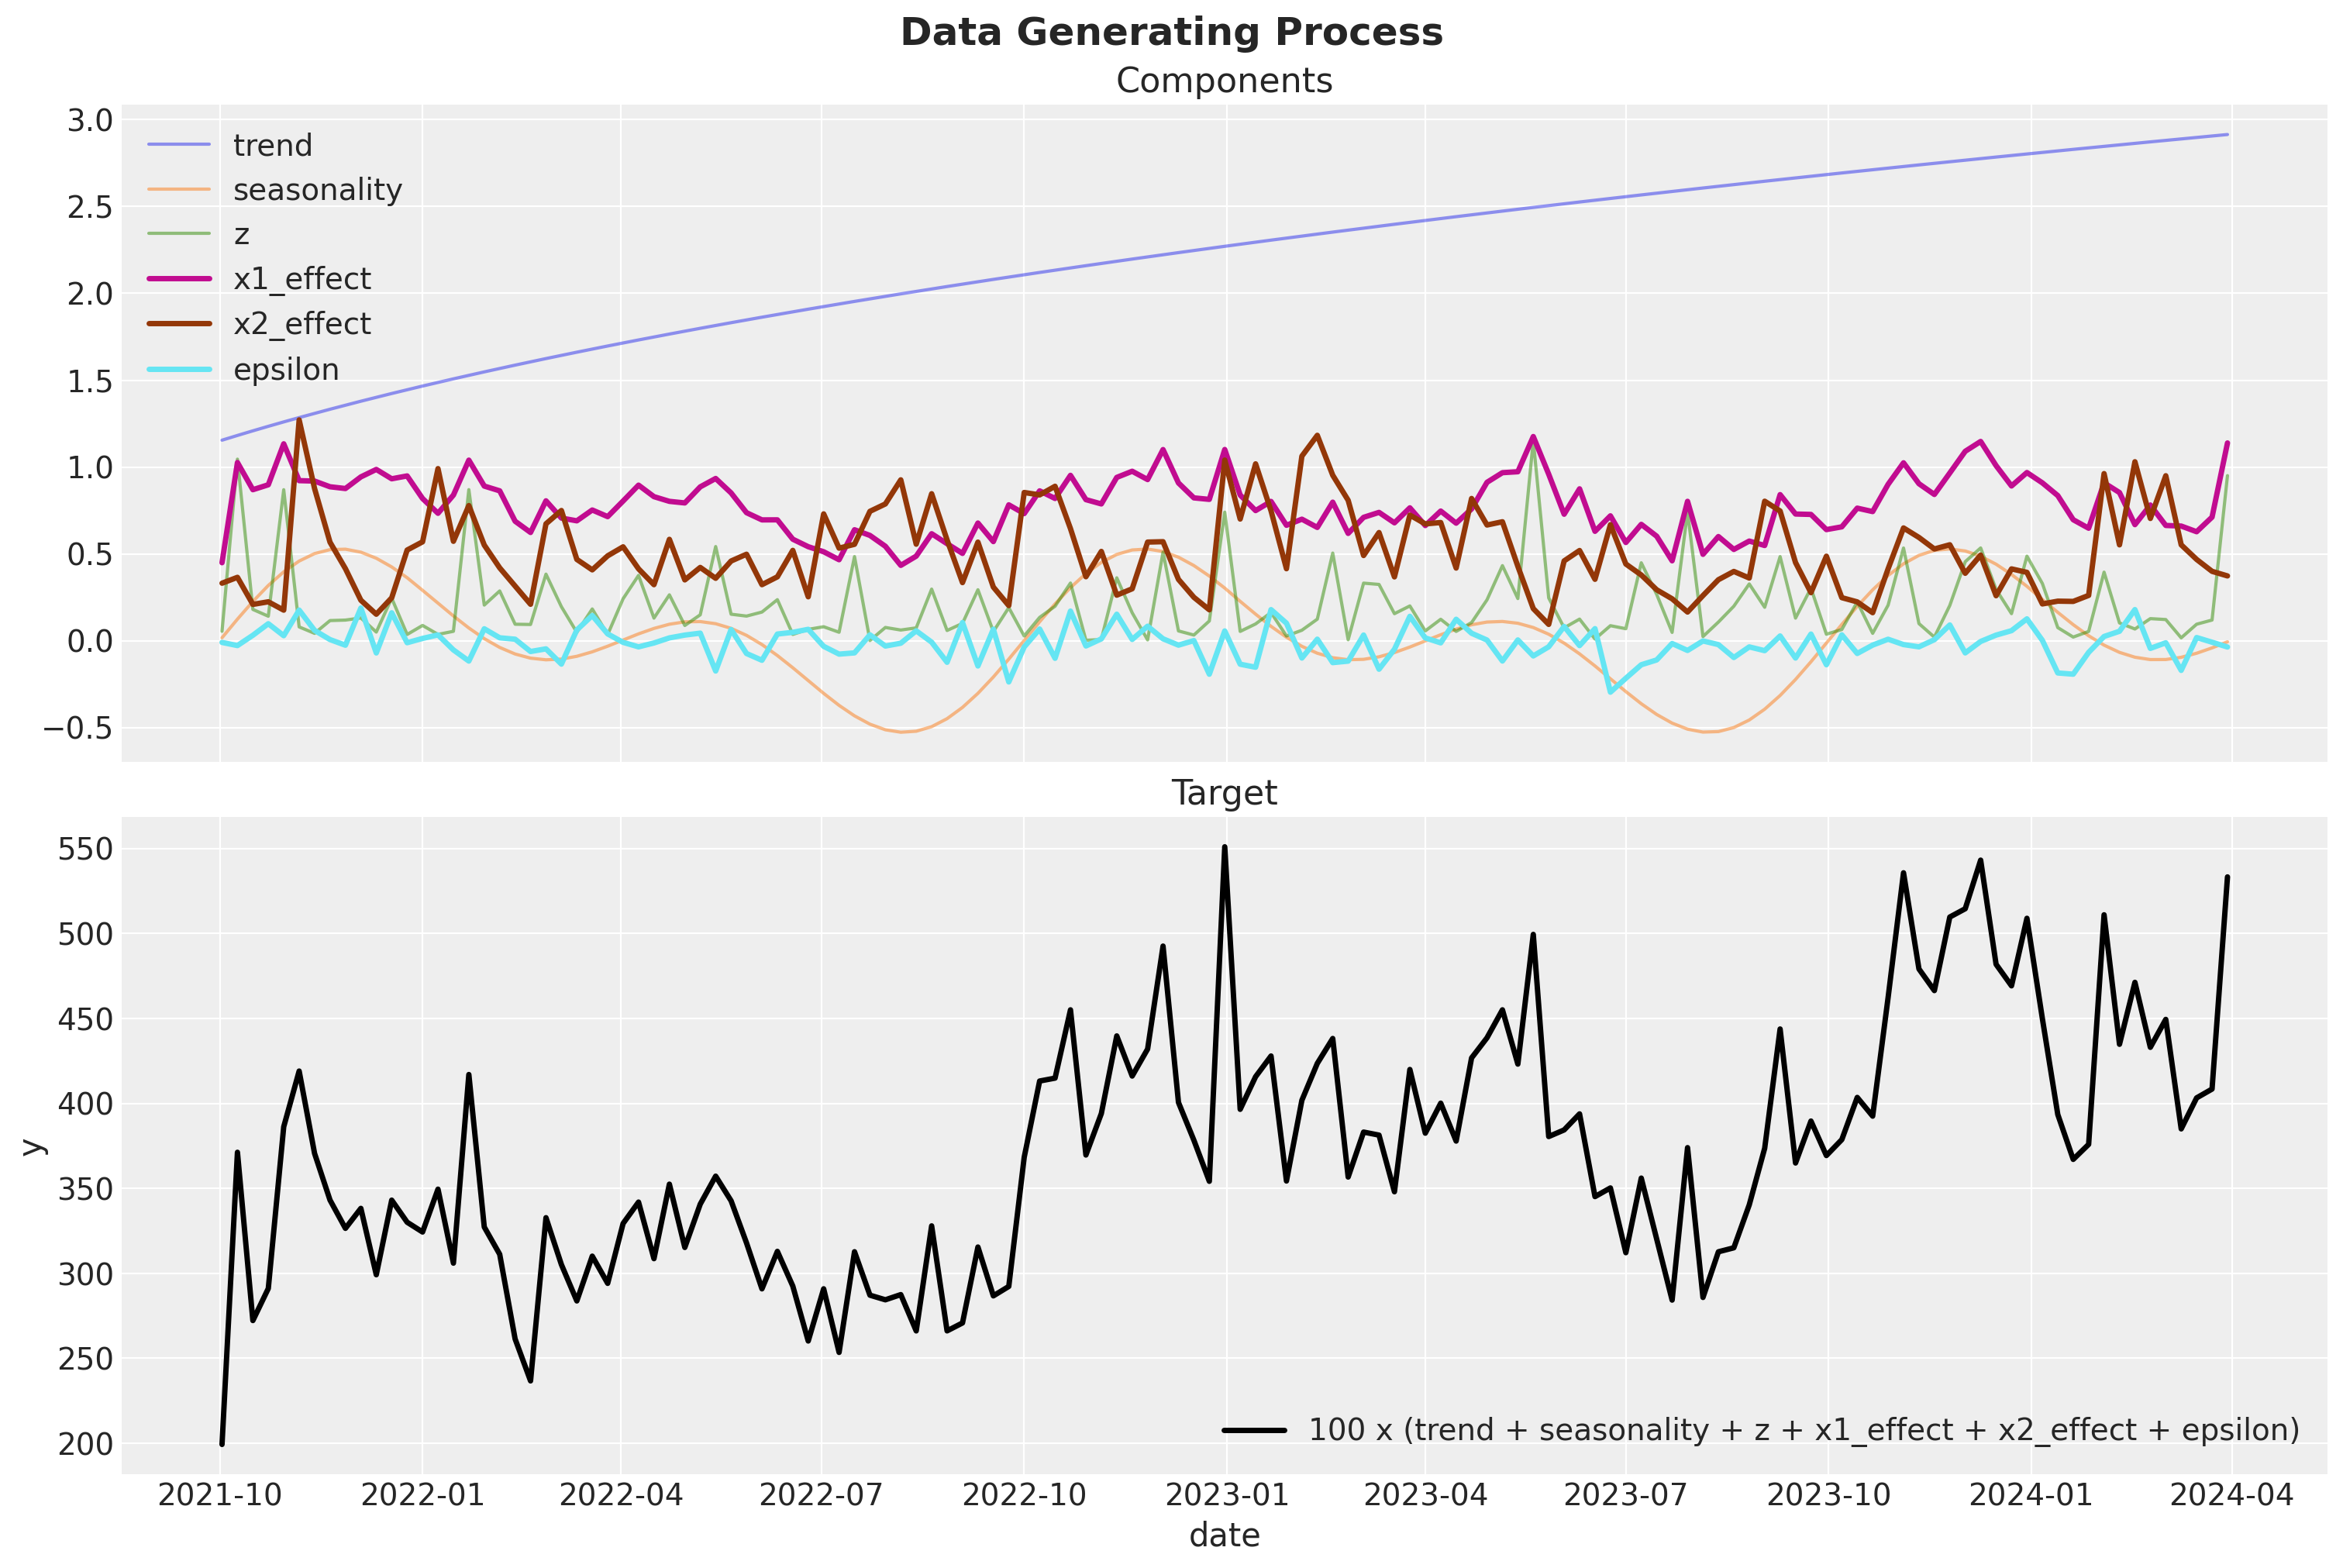

In [15]:
fig, ax = plt.subplots(
    nrows=2,
    ncols=1,
    figsize=(15, 10),
    sharex=True,
    sharey=False,
    layout="constrained",
)
sns.lineplot(
    data=data_df,
    x="date",
    y="trend",
    color="C0",
    alpha=0.5,
    label="trend",
    ax=ax[0],
)
sns.lineplot(
    data=data_df,
    x="date",
    y="seasonality",
    color="C1",
    alpha=0.5,
    label="seasonality",
    ax=ax[0],
)
sns.lineplot(data=data_df, x="date", y="z", color="C2", alpha=0.5, label="z", ax=ax[0])
sns.lineplot(
    data=data_df,
    x="date",
    y="x1_effect",
    color="C3",
    linewidth=2.5,
    label="x1_effect",
    ax=ax[0],
)
sns.lineplot(
    data=data_df,
    x="date",
    y="x2_effect",
    color="C4",
    linewidth=2.5,
    label="x2_effect",
    ax=ax[0],
)
sns.lineplot(
    data=data_df,
    x="date",
    y="epsilon",
    color="C5",
    linewidth=2.5,
    label="epsilon",
    ax=ax[0],
)
ax[0].legend(loc="upper left")
ax[0].set(title="Components", xlabel="date", ylabel=None)

sns.lineplot(
    data=data_df,
    x="date",
    y="y",
    color="black",
    linewidth=2.5,
    label="100 x (trend + seasonality + z + x1_effect + x2_effect + epsilon)",
    ax=ax[1],
)
ax[1].legend(loc="lower right")
ax[1].set(title="Target")

fig.suptitle(t="Data Generating Process", fontsize=18, fontweight="bold")

**Remark:** We are computing quantities `y01` and `y01` as the potential outcome sales when channels $x_1$ and $x_2$ are set to $0$. This is useful to compute the global ROAS (see below).

In [16]:
data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 131 entries, 0 to 130
Data columns (total 20 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   date                  131 non-null    datetime64[ns]
 1   dayofyear             131 non-null    int32         
 2   quarter               131 non-null    object        
 3   trend                 131 non-null    float64       
 4   cs                    131 non-null    float64       
 5   cc                    131 non-null    float64       
 6   seasonality           131 non-null    float64       
 7   z                     131 non-null    float64       
 8   x1                    131 non-null    float64       
 9   x2                    131 non-null    float64       
 10  epsilon               131 non-null    float64       
 11  x1_adstock            131 non-null    float64       
 12  x2_adstock            131 non-null    float64       
 13  x1_adstock_saturated

---

## ROAS

One of the key outputs of media mix models is the ROAS (return on advertising spend) which is defined as the ratio between the incremental sales and the media spend. In the following snippet of code we compute the ROAS analytically for each channel. We compute a globar ROAS as well as a quarterly ROAS. One has to be careful with the computation as we want to make sure we consider the carryover effects of the media channels. For example, if we compute the ROAS for the first week of the year, we need to consider the carryover effects of the media spend from the previous year.

The following function generate the sales when a given channel is turned off during a given period (note it mimics the data generating process described above). In the language of causal inference, this function computes the potential outcome when a given channel is turned off.

In [17]:
def generate_potential_y(
    dataset, alpha, l_max, lambda_, beta1, beta2, amplitude, channel, t0, t1
):
    dataset = dataset.copy()
    dataset["mask"] = ~dataset["date"].between(left=t0, right=t1, inclusive="both")
    dataset[channel] = dataset[channel].where(cond=dataset["mask"], other=0)
    dataset[["x1_adstock", "x2_adstock"]] = geometric_adstock(
        x=dataset[["x1", "x2"]], alpha=alpha, l_max=l_max, normalize=True
    ).eval()
    dataset[["x1_adstock_saturated", "x2_adstock_saturated"]] = logistic_saturation(
        x=dataset[["x1_adstock", "x2_adstock"]], lam=lambda_
    ).eval()
    return dataset.eval(
        f"""
        x1_effect = {beta1} * x1_adstock_saturated
        x2_effect = {beta2} * x2_adstock_saturated
        y = {amplitude} * (trend + seasonality + z + x1_effect + x2_effect + epsilon)
        """
    )

Let's test this function does generates our dataset above when we do not turn off any channel. We achieve this by setting the `t0` and `t1` arguments (which define the turn off period) outside of the data range.

In [18]:
for channel in ["x1", "x2"]:
    temp_df = generate_potential_y(
        dataset=data_df,
        alpha=alpha,
        l_max=l_max,
        lambda_=lam,
        beta1=beta1,
        beta2=beta2,
        amplitude=amplitude,
        channel=channel,
        t0=min_date - pd.Timedelta(days=7),
        t1=min_date - pd.Timedelta(days=7),
    )

    pd.testing.assert_frame_equal(left=temp_df[data_df.columns], right=data_df)

We proceed to generate the potential outcome sales for each channel and each quarter.

In [19]:
quarter_ranges = data_df.groupby("quarter", as_index=False).agg(
    {"date": ["min", "max"]}
)

quarter_ranges.head()

quarter       date           
                 min        max
0  2021Q4 2021-10-02 2021-12-25
1  2022Q1 2022-01-01 2022-03-26
2  2022Q2 2022-04-02 2022-06-25
3  2022Q3 2022-07-02 2022-09-24
4  2022Q4 2022-10-01 2022-12-31

In [20]:
roas_data = {
    channel: {
        row["quarter"].item(): generate_potential_y(
            dataset=data_df,
            alpha=alpha,
            l_max=l_max,
            lambda_=lam,
            beta1=beta1,
            beta2=beta2,
            amplitude=amplitude,
            channel=channel,
            t0=row["date"]["min"],
            t1=row["date"]["max"],
        )
        for _, row in tqdm(quarter_ranges.iterrows())
    }
    for channel in ["x1", "x2"]
}

0it [00:00, ?it/s]

0it [00:00, ?it/s]

We can visualize the potential outcome against the true sales for each quarter for the first channel $x_1$.

Text(0.5, 0.98, 'Actual vds Potential - x1')

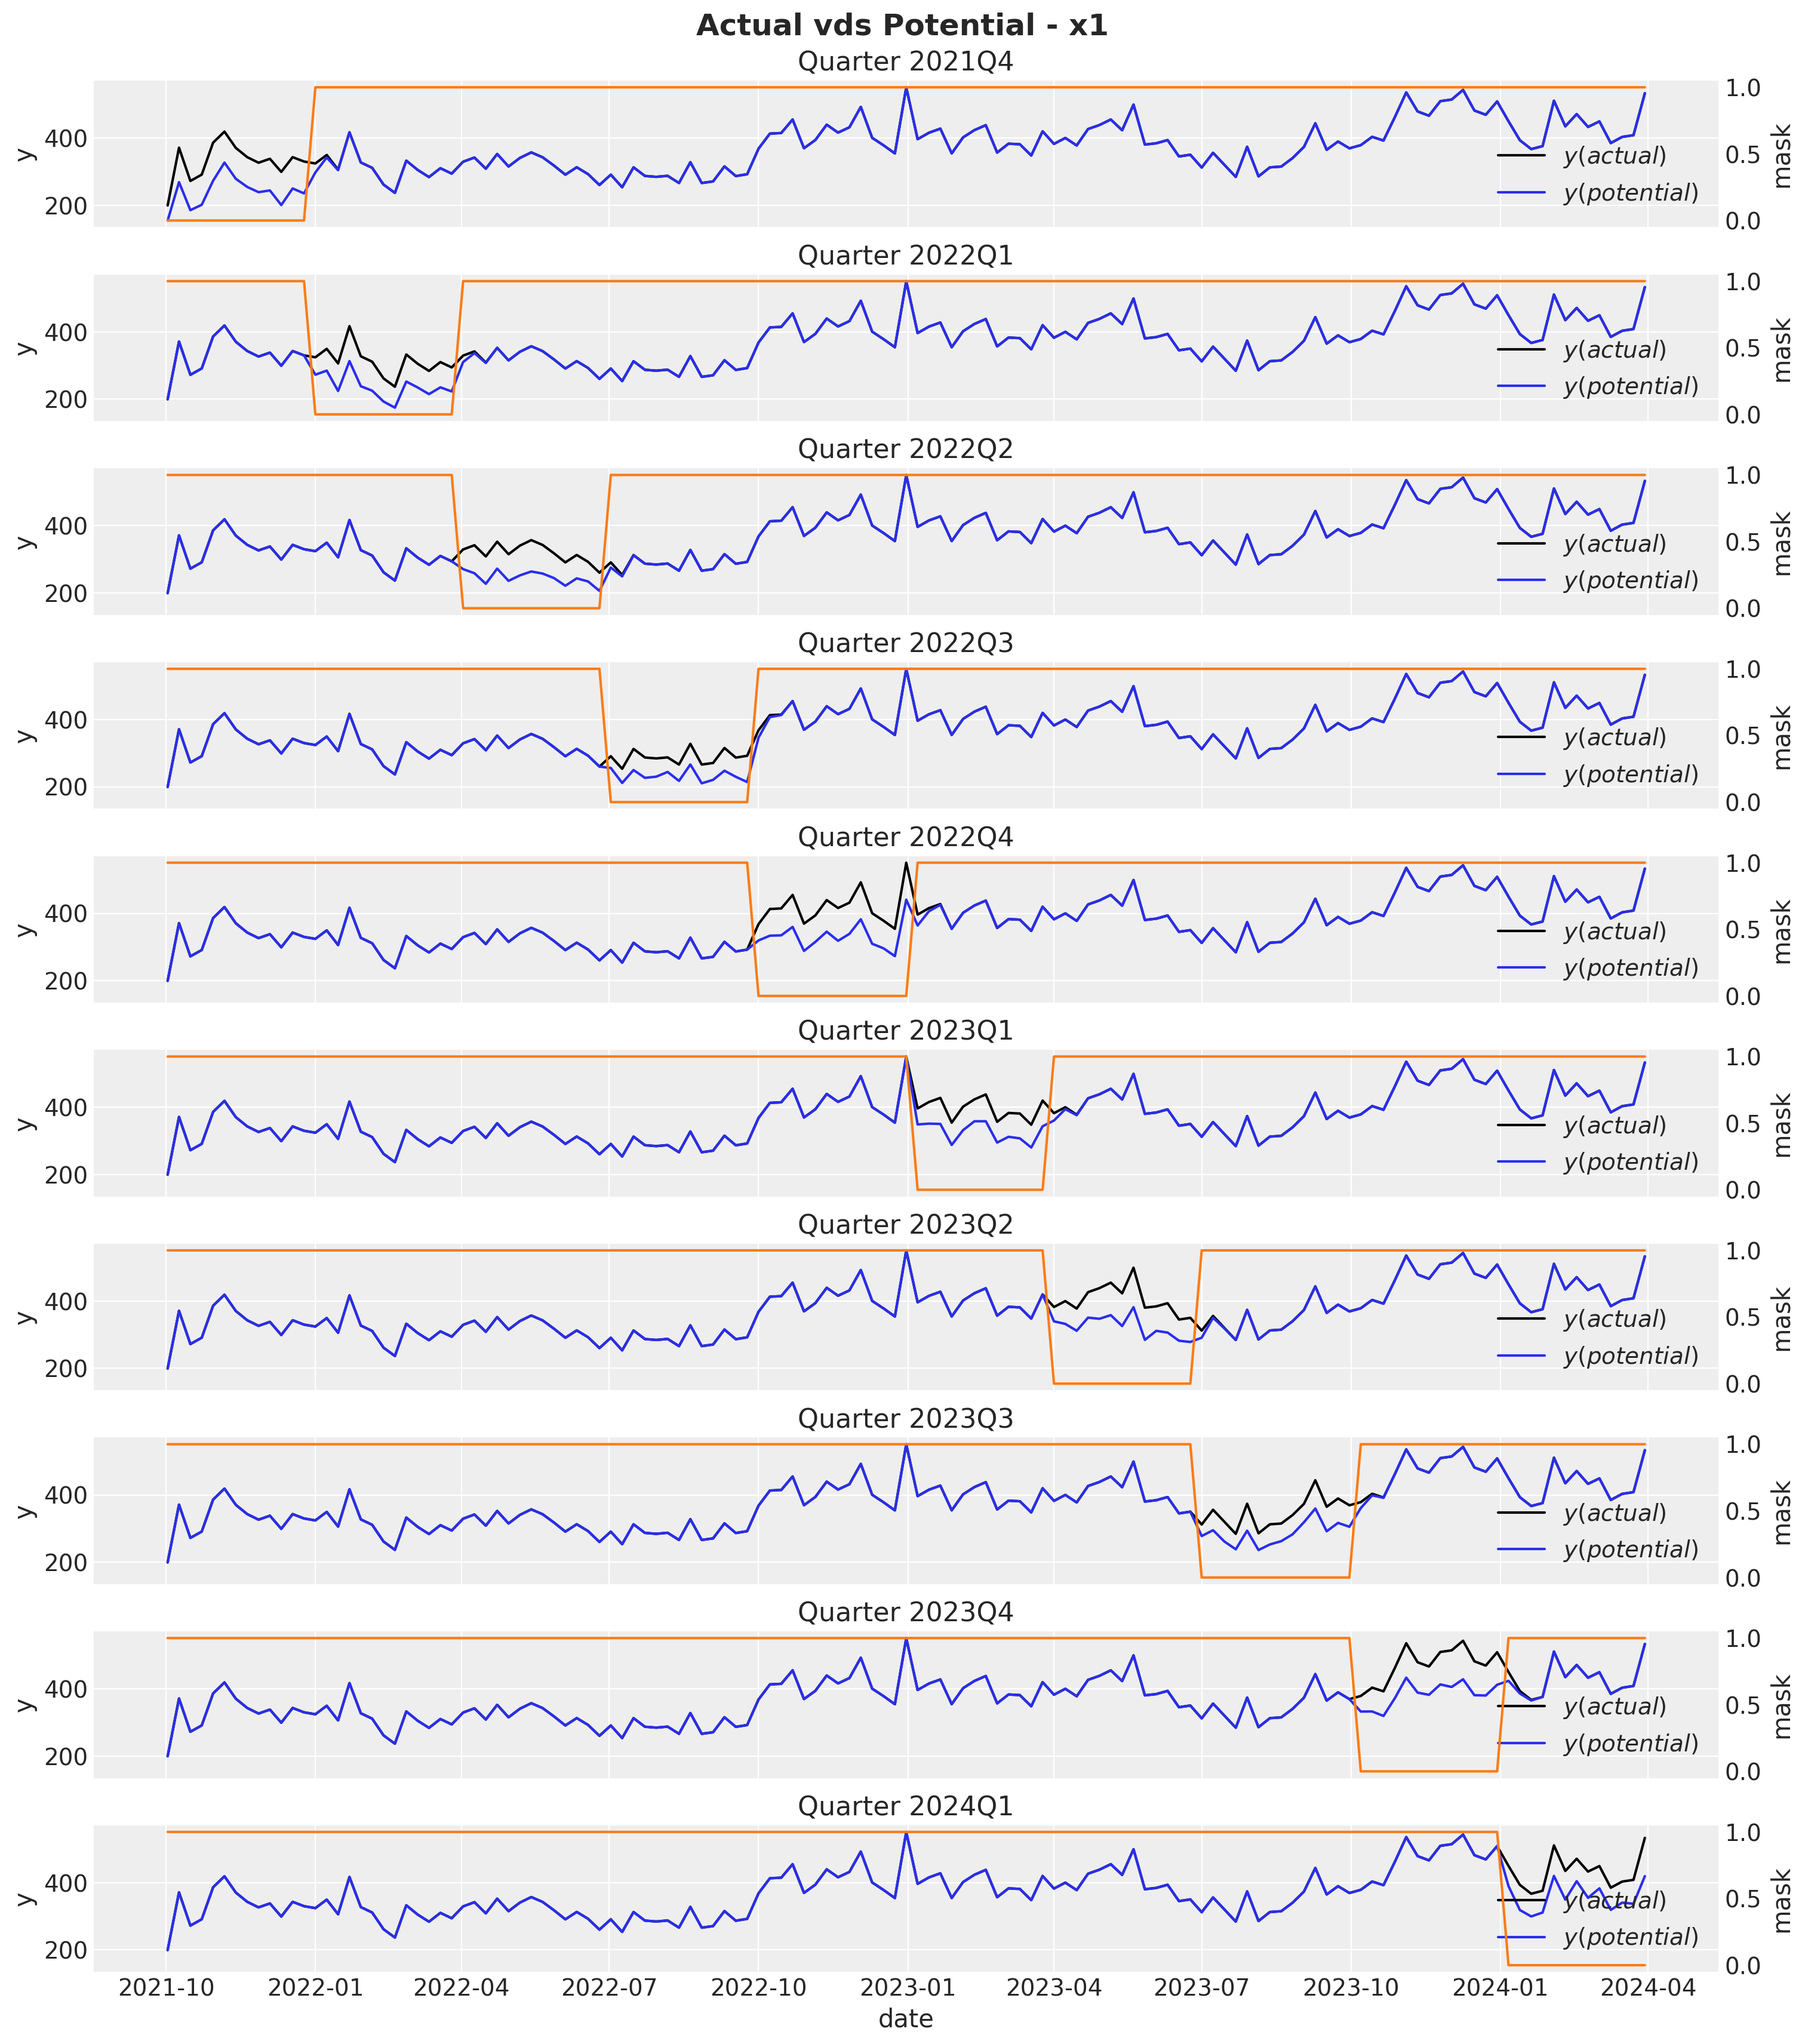

In [21]:
fig, axes = plt.subplots(
    nrows=quarter_ranges.quarter.nunique(),
    ncols=1,
    figsize=(15, 17),
    sharex=True,
    sharey=True,
    layout="constrained",
)

axes = axes.flatten()

for i, (q, q_df) in enumerate(roas_data["x1"].items()):
    ax = axes[i]
    ax_twin = ax.twinx()

    sns.lineplot(
        data=data_df, x="date", y="y", color="black", label="$y (actual)$", ax=ax
    )
    sns.lineplot(data=q_df, x="date", y="y", color="C0", label="$y (potential)$", ax=ax)
    sns.lineplot(data=q_df, x="date", y="mask", color="C1", ax=ax_twin)
    ax.set_title(f"Quarter {q}")
    ax_twin.grid(None)

fig.suptitle(t="Actual vds Potential - x1", fontsize=18, fontweight="bold")

Observe that the potential sales and the true sales differ immediately after the mask period as a result of the carryover effect of the media spend. Next, we compute the ROAS for each each quarter by simply dividing the difference between the potential sales and the true sales by the media spend.

In [22]:
roas_x1 = pd.DataFrame.from_dict(
    data={
        q: (
            (data_df["y"].sum() - q_df["y"].sum())
            / data_df.query("quarter == @q")["x1"].sum()
        )
        for q, q_df in roas_data["x1"].items()
    },
    orient="index",
    columns=["roas"],
).assign(channel="x1")

We can do the exact same procedure for channel $x_2$.

Text(0.5, 0.98, 'Actual vds Potential - x2')

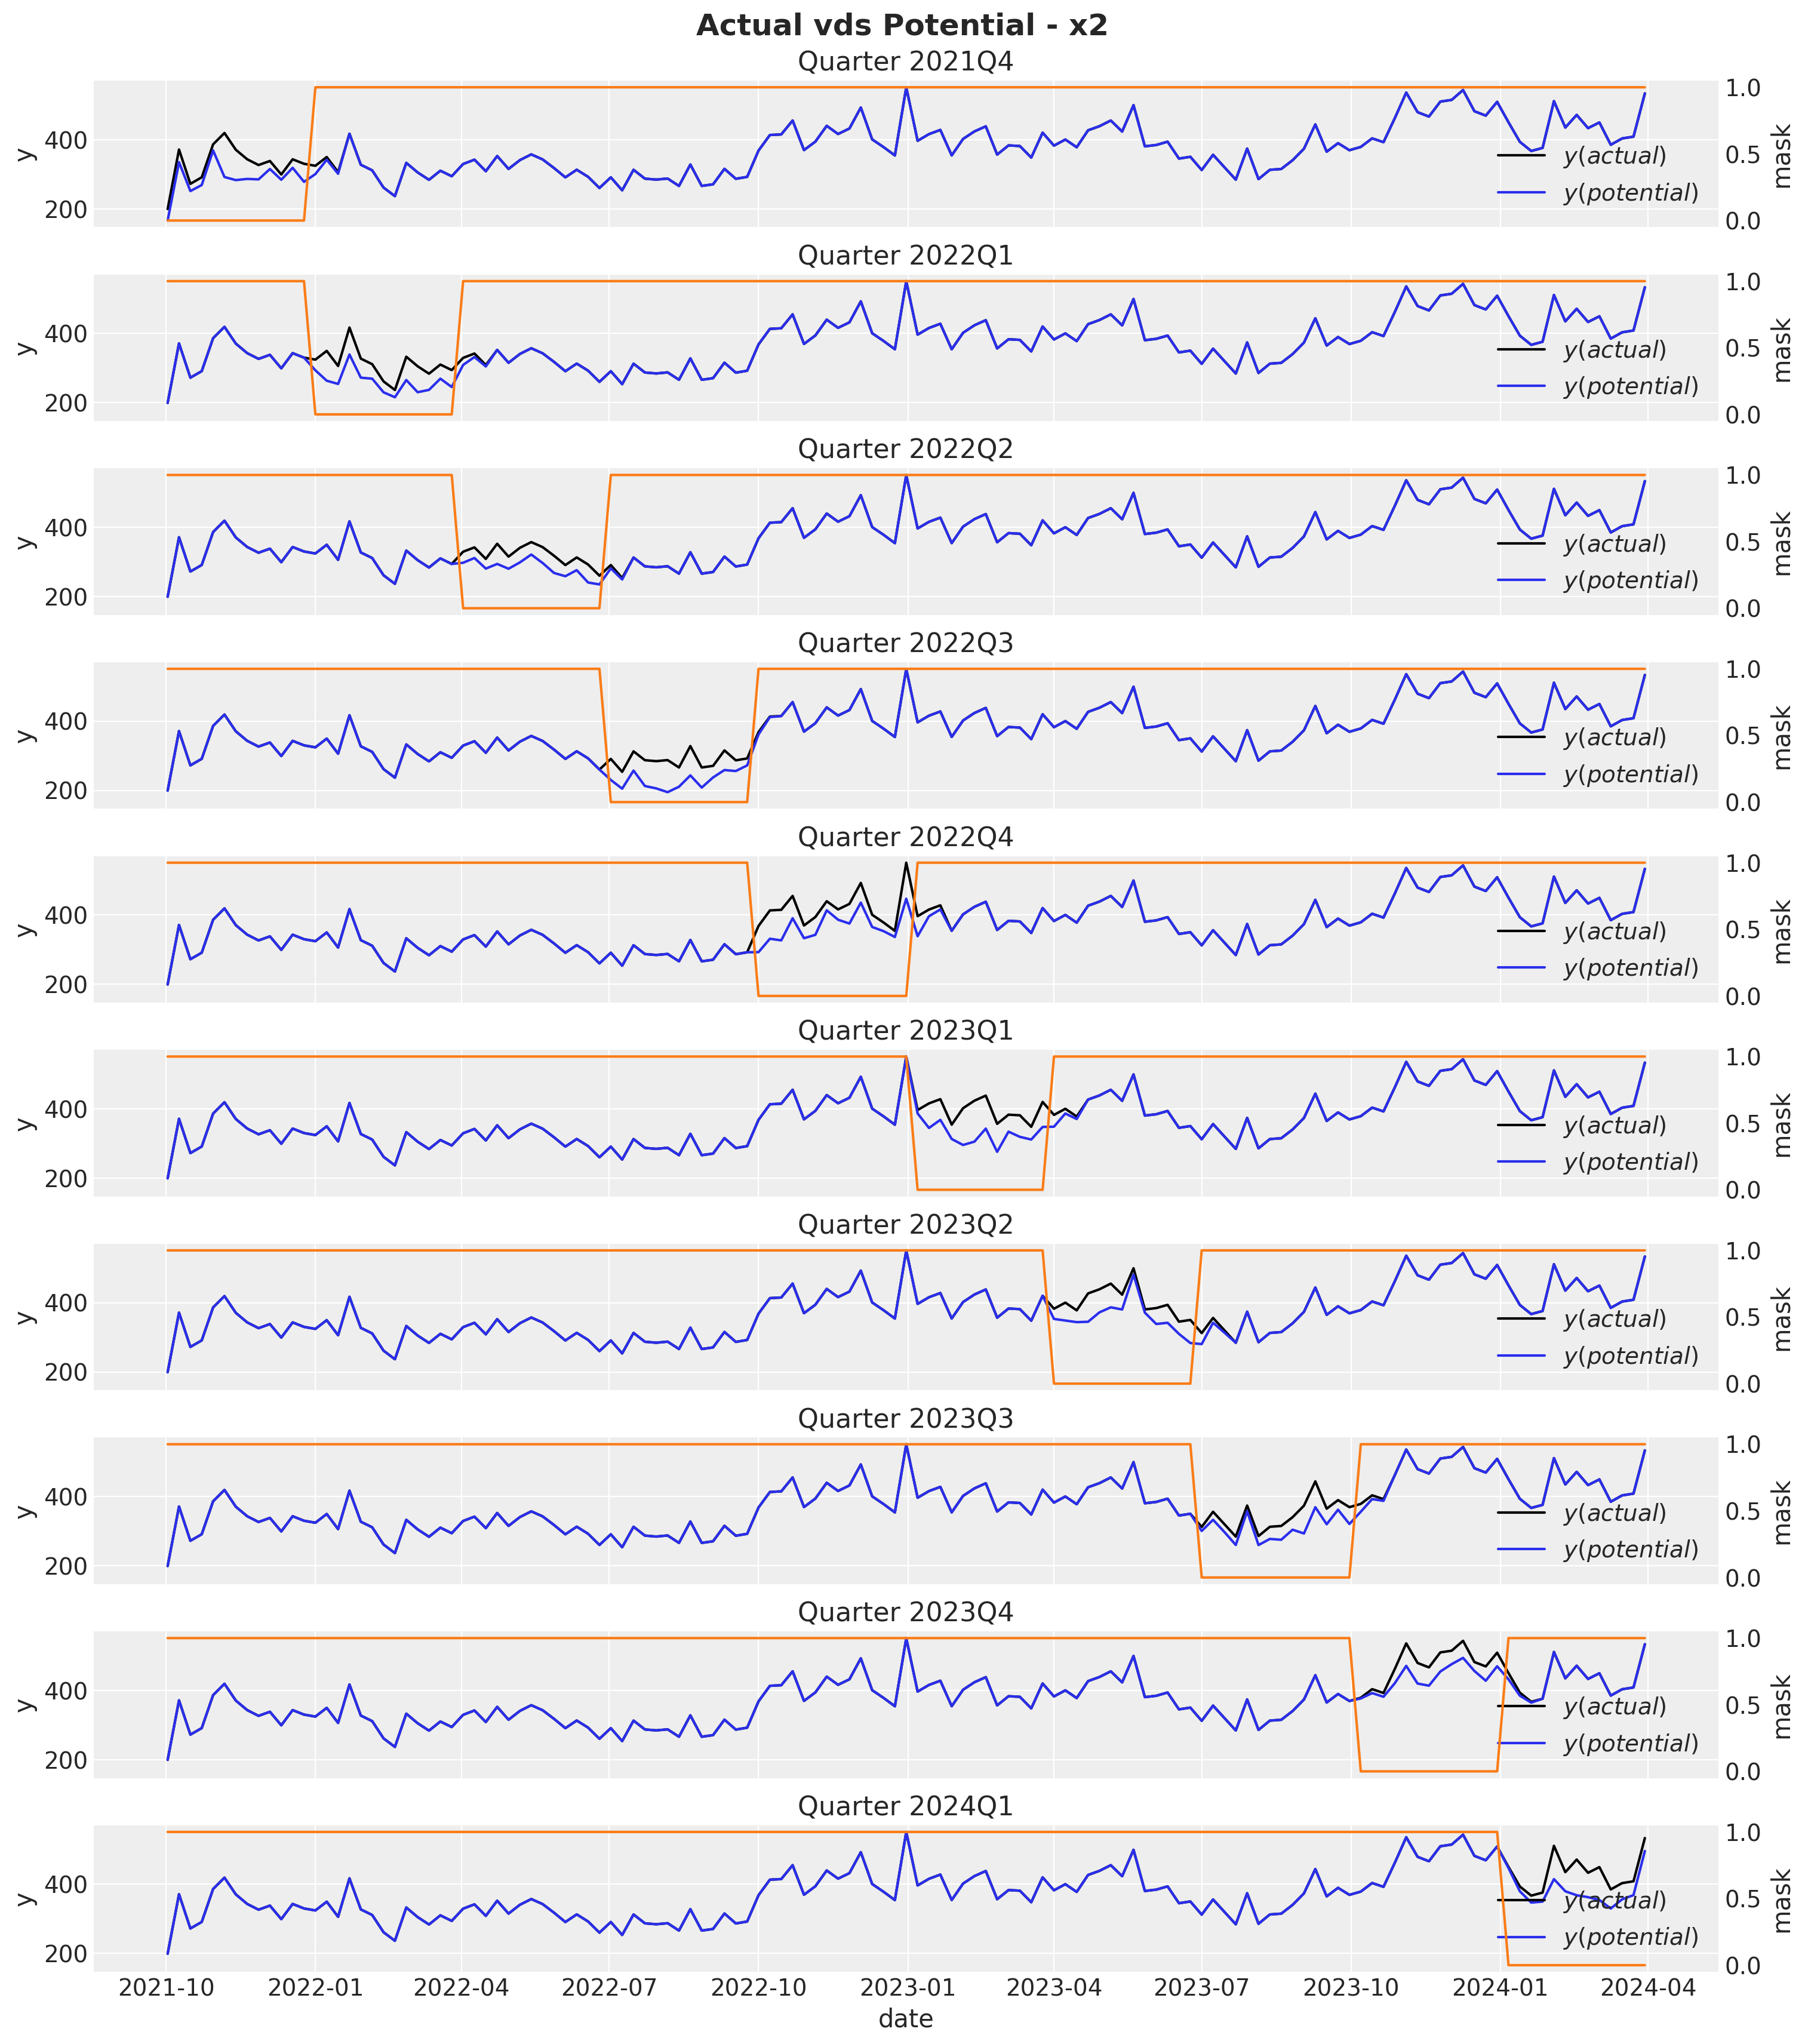

In [23]:
fig, axes = plt.subplots(
    nrows=quarter_ranges.quarter.nunique(),
    ncols=1,
    figsize=(15, 17),
    sharex=True,
    sharey=True,
    layout="constrained",
)

axes = axes.flatten()

for i, (q, q_df) in enumerate(roas_data["x2"].items()):
    ax = axes[i]
    ax_twin = ax.twinx()

    sns.lineplot(
        data=data_df, x="date", y="y", color="black", label="$y (actual)$", ax=ax
    )
    sns.lineplot(data=q_df, x="date", y="y", color="C0", label="$y (potential)$", ax=ax)
    sns.lineplot(data=q_df, x="date", y="mask", color="C1", ax=ax_twin)
    ax.set_title(f"Quarter {q}")
    ax_twin.grid(None)

fig.suptitle(t="Actual vds Potential - x2", fontsize=18, fontweight="bold")

In [24]:
roas_x2 = pd.DataFrame.from_dict(
    data={
        q: (
            (data_df["y"].sum() - q_df["y"].sum())
            / data_df.query("quarter == @q")["x2"].sum()
        )
        for q, q_df in roas_data["x2"].items()
    },
    orient="index",
    columns=["roas"],
).assign(channel="x2")

Moreover, we can easily compute the global ROAS:

In [25]:
roas_all_1 = (data_df["y"] - data_df["y01"]).sum() / data_df["x1"].sum()

roas_all_2 = (data_df["y"] - data_df["y02"]).sum() / data_df["x2"].sum()

Let's  visualize the quarterly and global ROAS for each channel:

/Users/juanitorduz/.local/share/virtualenvs/website_projects-1IZj_WTw/lib/python3.11/site-packages/seaborn/axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


Text(0.5, 1.03, 'True ROAS')

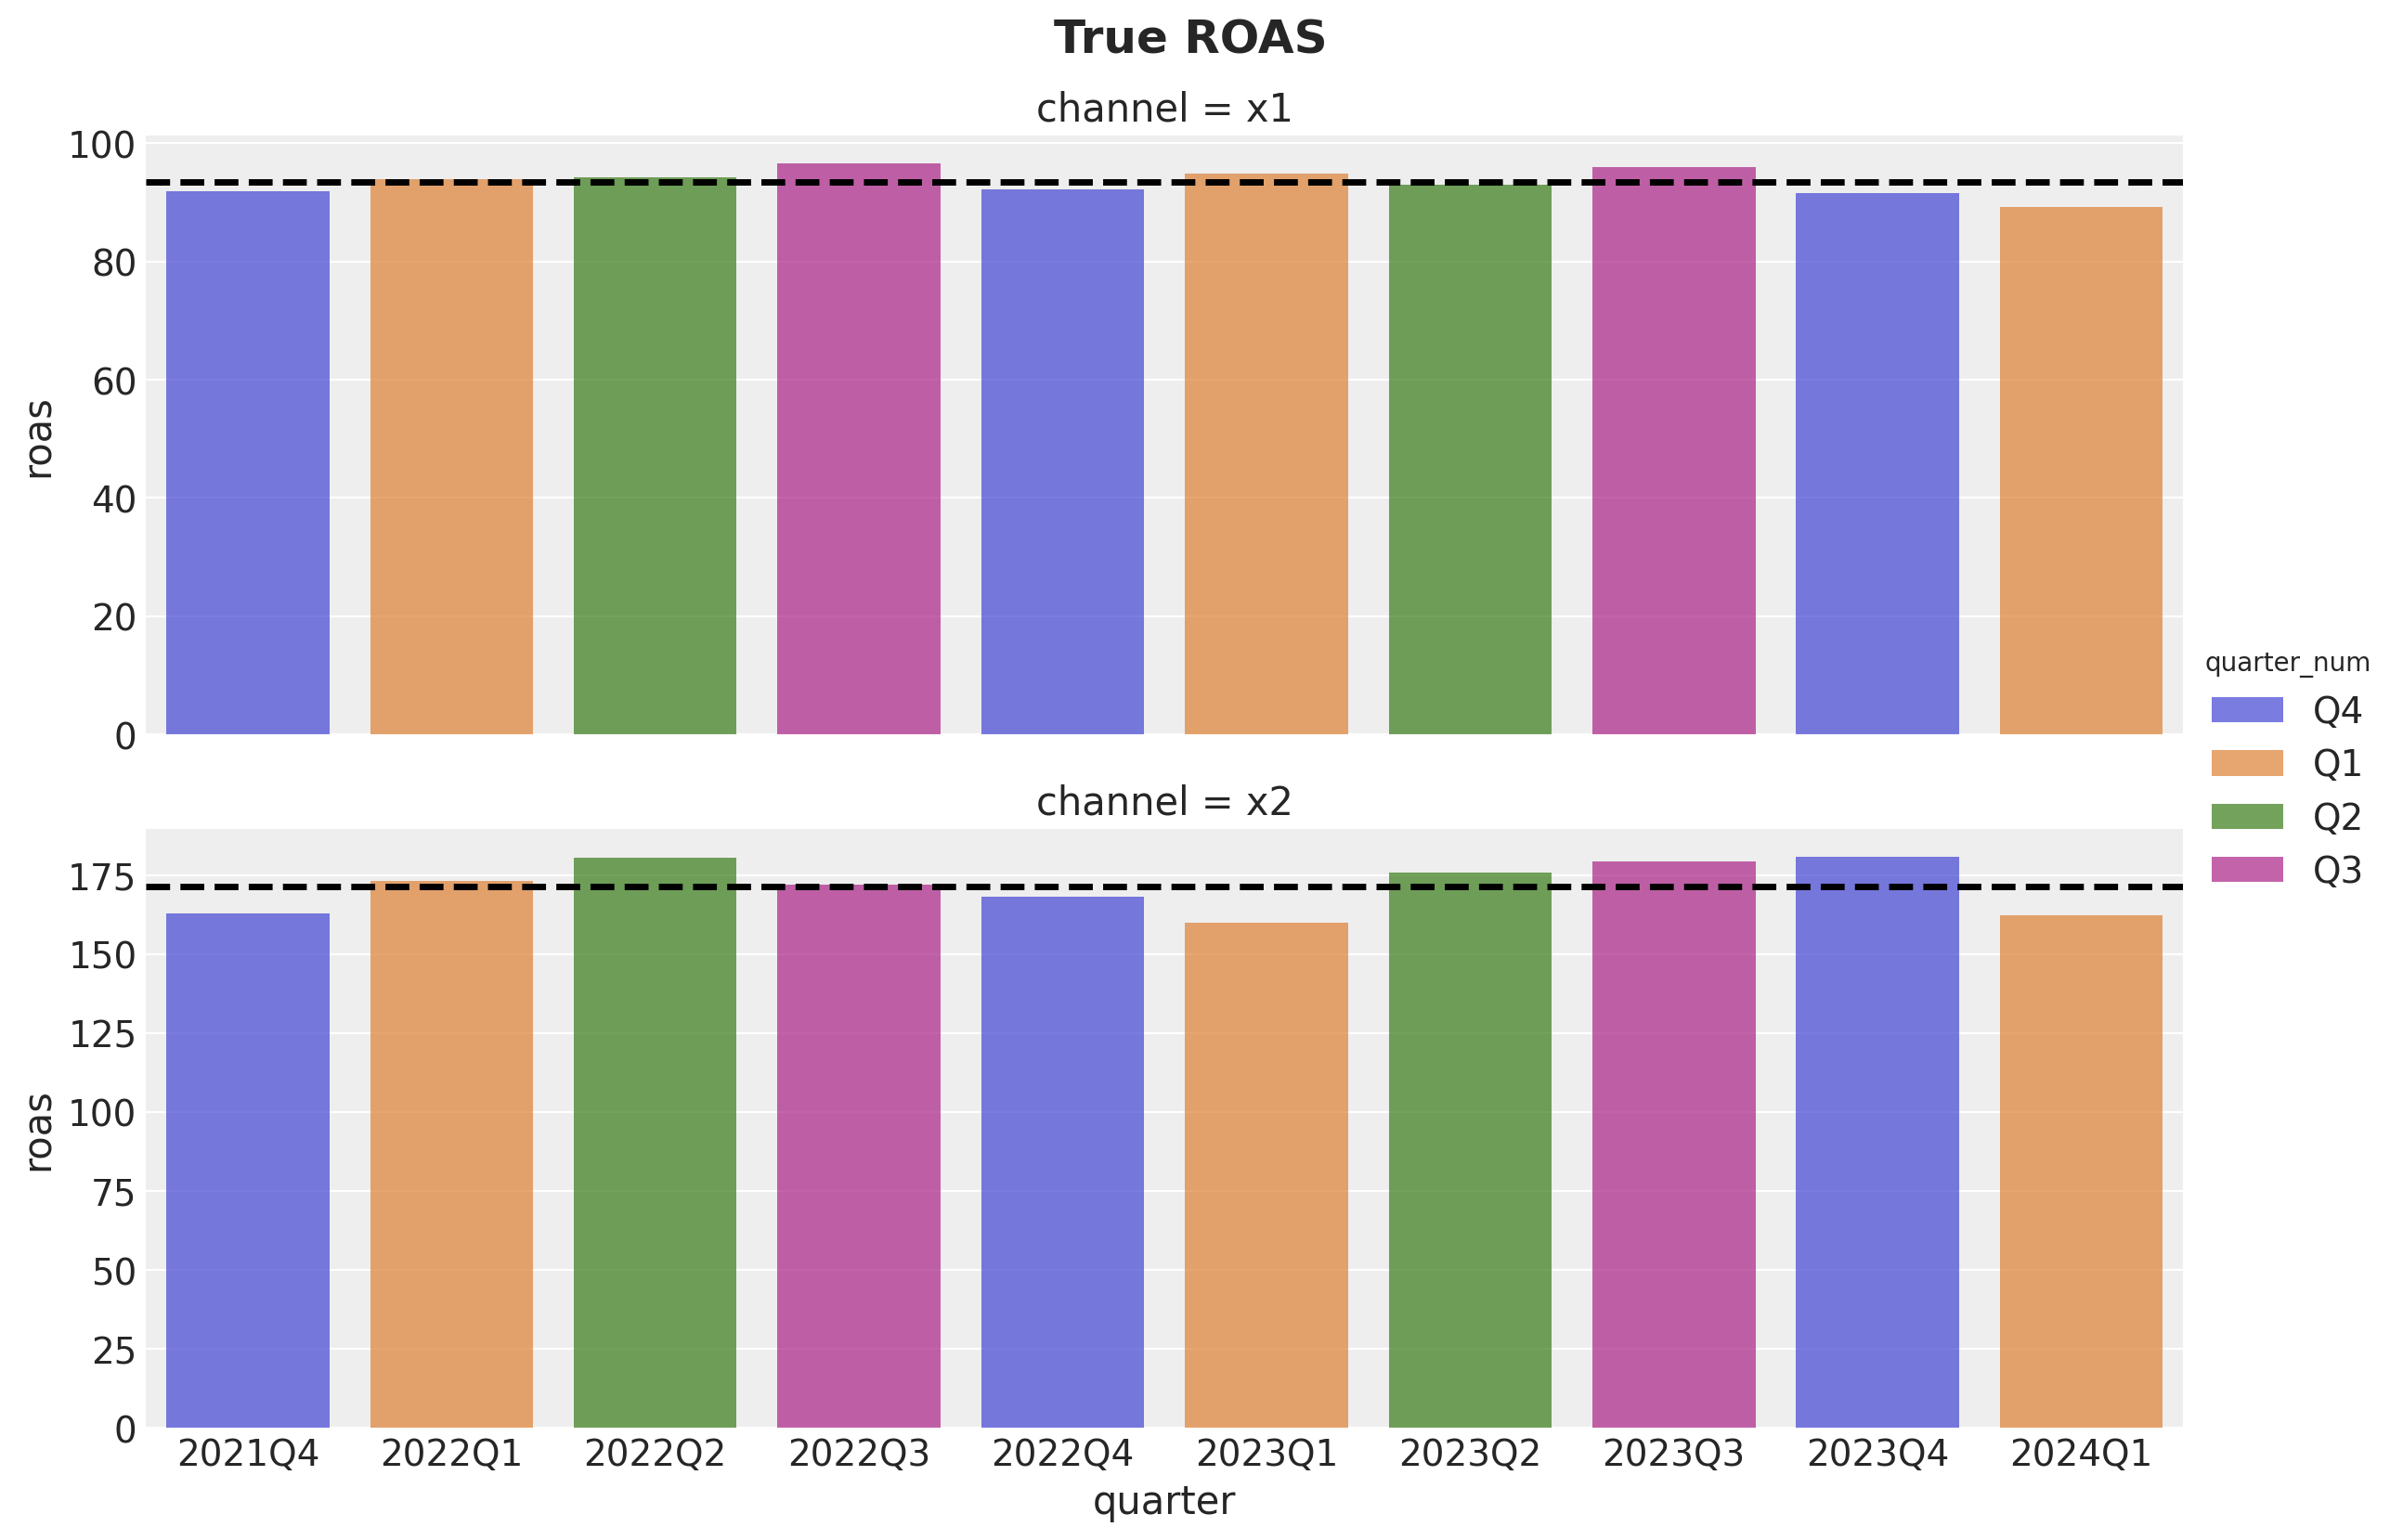

In [26]:
roas = (
    pd.concat(objs=[roas_x1, roas_x2], axis=0)
    .reset_index(drop=False)
    .rename(columns={"index": "quarter"})
)

g = sns.catplot(
    data=roas.assign(quarter_num=lambda df: df.quarter.str[4:]),
    x="quarter",
    y="roas",
    row="channel",
    hue="quarter_num",
    kind="bar",
    height=4,
    aspect=3,
    alpha=0.7,
    sharey=False,
)

ax = g.axes.flatten()
ax[0].axhline(
    y=roas_all_1, color="black", linestyle="--", linewidth=2.5, label="roas (all)"
)
ax[1].axhline(
    y=roas_all_2, color="black", linestyle="--", linewidth=2.5, label="roas (all)"
)

g.fig.suptitle(t="True ROAS", fontsize=18, fontweight="bold", y=1.03)

We see that channel $x_2$ has approximately $75\%$ higher ROAS as compared to channel $x_1$.

---

## Data Preparation

In [ ]:
columns_to_keep = [
    "date",
    "dayofyear",
    "z",
    "x1",
    "x2",
    "y",
]

model_df = data_df[columns_to_keep]

model_df.head()

In [ ]:
date = model_df["date"]

index_scaler = MaxAbsScaler()
index_scaled = index_scaler.fit_transform(model_df.reset_index(drop=False)[["index"]])

target = "y"
target_scaler = MaxAbsScaler()
target_scaled = target_scaler.fit_transform(model_df[[target]])

channels = ["x1", "x2"]
channels_scaler = MaxAbsScaler()
channels_scaled = channels_scaler.fit_transform(model_df[channels])

controls = ["z"]
controls_scaler = MaxAbsScaler()
controls_scaled = controls_scaler.fit_transform(model_df[controls])

In [ ]:
n_order = 3
periods = model_df["dayofyear"] / 365.25
fourier_features = pd.DataFrame(
    {
        f"{func}_order_{order}": getattr(np, func)(2 * np.pi * periods * order)
        for order in range(1, n_order + 1)
        for func in ("sin", "cos")
    }
)

---

## Model Parametrization 1

In [ ]:
fig, ax = plt.subplots(figsize=(10, 6))
pz.Beta(alpha=2, beta=3).plot_pdf(ax=ax)
ax.set(xlabel="x", ylabel=r"$\alpha$")
ax.set_title(label=r"Prior Distribution $\alpha$", fontsize=18, fontweight="bold")

In [ ]:
fig, ax = plt.subplots(figsize=(10, 6))
pz.Gamma(alpha=2, beta=2).plot_pdf(ax=ax)
ax.set(xlabel="x", ylabel=r"$\lambda$")
ax.set_title(label=r"Prior Distribution $\lambda$", fontsize=18, fontweight="bold")

In [ ]:
channel_share = data_df[channels].sum() / data_df[channels].sum().sum()
channel_share.head()

In [ ]:
fig, ax = plt.subplots(figsize=(10, 6))
pz.HalfNormal(sigma=channel_share.loc["x1"]).plot_pdf(ax=ax)
pz.HalfNormal(sigma=channel_share.loc["x2"]).plot_pdf(ax=ax)
ax.set(xlabel="x", ylabel=r"$\beta$")
ax.set_title(label=r"Prior Distribution $\beta$", fontsize=18, fontweight="bold")

In [ ]:
coords = {"date": date, "channel": channels, "fourier_mode": np.arange(2 * n_order)}

In [ ]:
with pm.Model(coords=coords) as model_1:
    # --- Data Containers ---

    index_scaled_data = pm.Data(
        name="index_scaled",
        value=index_scaled.to_numpy().flatten(),
        mutable=True,
        dims="date",
    )

    channels_scaled_data = pm.Data(
        name="channels_scaled",
        value=channels_scaled,
        mutable=True,
        dims=("date", "channel"),
    )

    z_scaled_data = pm.Data(
        name="z_scaled",
        value=controls_scaled.to_numpy().flatten(),
        mutable=True,
        dims="date",
    )

    fourier_features_data = pm.Data(
        name="fourier_features",
        value=fourier_features,
        mutable=True,
        dims=("date", "fourier_mode"),
    )

    y_scaled_data = pm.Data(
        name="y_scaled",
        value=target_scaled.to_numpy().flatten(),
        mutable=True,
        dims="date",
    )

    # --- Priors ---

    amplitude_trend = pm.HalfNormal(name="amplitude_trend", sigma=1)
    ls_trend_params = pm.find_constrained_prior(
        distribution=pm.InverseGamma,
        lower=0.1,
        upper=0.9,
        init_guess={"alpha": 3, "beta": 1},
        mass=0.95,
    )
    ls_trend = pm.InverseGamma(name="ls_trend", **ls_trend_params)

    alpha = pm.Beta(name="alpha", alpha=2, beta=3, dims="channel")
    lam = pm.Gamma(name="lam", alpha=2, beta=2, dims="channel")
    # beta_channel = pm.Gamma(
    #     name="beta_channel",
    #     alpha=2,
    #     beta=6,
    #     dims="channel",
    # )
    beta_channel = pm.HalfNormal(
        name="beta_channel",
        sigma=channel_share.to_numpy(),
        dims="channel",
    )
    beta_z = pm.Normal(name="beta_z", mu=0, sigma=1)
    beta_fourier = pm.Normal(name="beta_fourier", mu=0, sigma=1, dims="fourier_mode")

    sigma = pm.HalfNormal(name="sigma", sigma=1)
    nu = pm.Gamma(name="nu", alpha=25, beta=2)

    # --- Parametrization ---

    cov_trend = amplitude_trend * pm.gp.cov.ExpQuad(input_dim=1, ls=ls_trend)
    gp_trend = pm.gp.HSGP(m=[20], c=1.5, cov_func=cov_trend)
    f_trend = gp_trend.prior(name="f_trend", X=index_scaled_data[:, None], dims="date")

    channel_adstock = pm.Deterministic(
        name="channel_adstock",
        var=geometric_adstock(
            x=channels_scaled_data,
            alpha=alpha,
            l_max=l_max,
            normalize=True,
        ),
        dims=("date", "channel"),
    )
    channel_adstock_saturated = pm.Deterministic(
        name="channel_adstock_saturated",
        var=logistic_saturation(x=channel_adstock, lam=lam),
        dims=("date", "channel"),
    )
    channel_contributions = pm.Deterministic(
        name="channel_contributions",
        var=channel_adstock_saturated * beta_channel,
        dims=("date", "channel"),
    )

    fourier_contribution = pm.Deterministic(
        name="fourier_contribution",
        var=pt.dot(fourier_features_data, beta_fourier),
        dims="date",
    )

    z_contribution = pm.Deterministic(
        name="z_contribution",
        var=z_scaled_data * beta_z,
        dims="date",
    )

    mu = pm.Deterministic(
        name="mu",
        var=f_trend
        + channel_contributions.sum(axis=-1)
        + z_contribution
        + fourier_contribution,
        dims="date",
    )

    # --- Likelihood ---
    y = pm.StudentT(
        name="y",
        nu=nu,
        mu=mu,
        sigma=sigma,
        observed=y_scaled_data,
        dims="date",
    )

pm.model_to_graphviz(model=model_1)

## Prior Predictive Checks

In [ ]:
with model_1:
    prior_predictive_1 = pm.sample_prior_predictive(samples=2_000, random_seed=rng)

In [ ]:
fig, ax = plt.subplots()
az.plot_ppc(data=prior_predictive_1, group="prior", kind="kde", ax=ax)
ax.set_title(label="Prior Predictive - Model 1", fontsize=18, fontweight="bold")

In [ ]:
with model_1:
    idata_1 = pm.sample(
        draws=2_000,
        chains=5,
        nuts_sampler="numpyro",
        random_seed=rng,
    )
    posterior_predictive_1 = pm.sample_posterior_predictive(
        trace=idata_1, random_seed=rng
    )

In [ ]:
idata_1["sample_stats"]["diverging"].sum().item()

In [ ]:
var_names = [
    "amplitude_trend",
    "ls_trend",
    "alpha",
    "lam",
    "beta_channel",
    "beta_z",
    "beta_fourier",
    "sigma",
    "nu",
]

az.summary(data=idata_1, var_names=var_names, round_to=3)

In [ ]:
axes = az.plot_trace(
    data=idata_1,
    var_names=var_names,
    compact=True,
    backend_kwargs={"figsize": (15, 17), "layout": "constrained"},
)
plt.gcf().suptitle("Trace - Model 1", fontsize=16)

In [ ]:
pp_vars_original_scale_1 = {
    var_name: xr.apply_ufunc(
        target_scaler.inverse_transform,
        idata_1["posterior"][var_name].expand_dims(dim={"_": 1}, axis=-1),
        input_core_dims=[["date", "_"]],
        output_core_dims=[["date", "_"]],
        vectorize=True,
    ).squeeze(dim="_")
    for var_name in ["mu", "f_trend", "fourier_contribution", "z_contribution"]
}

In [ ]:
pp_vars_original_scale_1["channel_contributions"] = xr.apply_ufunc(
    target_scaler.inverse_transform,
    idata_1["posterior"]["channel_contributions"],
    input_core_dims=[["date", "channel"]],
    output_core_dims=[["date", "channel"]],
    vectorize=True,
)

pp_vars_original_scale_1["baseline"] = xr.apply_ufunc(
    target_scaler.inverse_transform,
    (
        idata_1["posterior"]["f_trend"]
        + idata_1["posterior"]["fourier_contribution"]
        + idata_1["posterior"]["z_contribution"]
    ).expand_dims(dim={"_": 1}, axis=-1),
    input_core_dims=[["date", "_"]],
    output_core_dims=[["date", "_"]],
    vectorize=True,
).squeeze(dim="_")

In [ ]:
pp_likelihood_original_scale_1 = xr.apply_ufunc(
    target_scaler.inverse_transform,
    posterior_predictive_1["posterior_predictive"]["y"].expand_dims(
        dim={"_": 1}, axis=-1
    ),
    input_core_dims=[["date", "_"]],
    output_core_dims=[["date", "_"]],
    vectorize=True,
).squeeze(dim="_")

In [ ]:
fig, ax = plt.subplots()
sns.lineplot(data=model_df, x="date", y="y", color="black", label=target, ax=ax)
az.plot_hdi(
    x=date,
    y=pp_likelihood_original_scale_1,
    hdi_prob=0.94,
    color="C0",
    fill_kwargs={"alpha": 0.1, "label": r"likelihood $94\%$ HDI"},
    smooth=False,
    ax=ax,
)
az.plot_hdi(
    x=date,
    y=pp_vars_original_scale_1["mu"],
    hdi_prob=0.94,
    color="C0",
    fill_kwargs={"alpha": 0.3, "label": r"$\mu$ $94\%$ HDI"},
    smooth=False,
    ax=ax,
)
ax.legend(loc="upper left")
ax.set_title(label="Posterior Predictive - Model 1", fontsize=18, fontweight="bold")

In [ ]:
fig, ax = plt.subplots()
sns.lineplot(data=model_df, x="date", y="y", color="black", label=target, ax=ax)
az.plot_hdi(
    x=date,
    y=pp_vars_original_scale_1["channel_contributions"].sel(channel="x1"),
    hdi_prob=0.94,
    color="C0",
    fill_kwargs={"alpha": 0.5, "label": r"$x1$ contribution $94\%$ HDI"},
    smooth=False,
    ax=ax,
)
az.plot_hdi(
    x=date,
    y=pp_vars_original_scale_1["channel_contributions"].sel(channel="x2"),
    hdi_prob=0.94,
    color="C1",
    fill_kwargs={"alpha": 0.5, "label": r"$x2$ contribution $94\%$ HDI"},
    smooth=False,
    ax=ax,
)
az.plot_hdi(
    x=date,
    y=pp_vars_original_scale_1["f_trend"],
    hdi_prob=0.94,
    color="C2",
    fill_kwargs={"alpha": 0.3, "label": r"$f_\text{trend}$ $94\%$ HDI"},
    smooth=False,
    ax=ax,
)
az.plot_hdi(
    x=date,
    y=pp_vars_original_scale_1["fourier_contribution"],
    hdi_prob=0.94,
    color="C3",
    fill_kwargs={"alpha": 0.3, "label": r"seasonality $94\%$ HDI"},
    smooth=False,
    ax=ax,
)
az.plot_hdi(
    x=date,
    y=pp_vars_original_scale_1["z_contribution"],
    hdi_prob=0.94,
    color="C4",
    fill_kwargs={"alpha": 0.3, "label": r"$z$ contribution $94\%$ HDI"},
    smooth=False,
    ax=ax,
)
ax.legend(loc="upper center", bbox_to_anchor=(0.5, -0.1), ncol=3)
ax.set_title(label="Components Contributions - Model 1", fontsize=18, fontweight="bold")

In [ ]:
fig, ax = plt.subplots()
sns.lineplot(data=model_df, x="date", y="y", color="black", label=target, ax=ax)
az.plot_hdi(
    x=date,
    y=pp_vars_original_scale_1["channel_contributions"].sel(channel="x1"),
    hdi_prob=0.94,
    color="C0",
    fill_kwargs={"alpha": 0.5, "label": r"$x1$ contribution $94\%$ HDI"},
    smooth=False,
    ax=ax,
)
az.plot_hdi(
    x=date,
    y=pp_vars_original_scale_1["channel_contributions"].sel(channel="x2"),
    hdi_prob=0.94,
    color="C1",
    fill_kwargs={"alpha": 0.5, "label": r"$x2$ contribution $94\%$ HDI"},
    smooth=False,
    ax=ax,
)
az.plot_hdi(
    x=date,
    y=pp_vars_original_scale_1["baseline"],
    hdi_prob=0.94,
    color="C7",
    fill_kwargs={"alpha": 0.5, "label": r"baseline $94\%$ HDI"},
    smooth=False,
    ax=ax,
)
ax.legend(loc="upper left")
ax.set_title(label="Baseline vs Channels - Model 1", fontsize=18, fontweight="bold")

In [ ]:
fig, ax = plt.subplots(
    nrows=2, ncols=1, figsize=(12, 7), sharex=True, sharey=False, layout="constrained"
)
sns.lineplot(
    x="date",
    y="x1_effect",
    data=data_df.assign(x1_effect=lambda x: amplitude * x["x1_effect"]),
    color="C0",
    label=r"$x1$ effect",
    ax=ax[0],
)
az.plot_hdi(
    x=date,
    y=pp_vars_original_scale_1["channel_contributions"].sel(channel="x1"),
    hdi_prob=0.94,
    color="C0",
    fill_kwargs={"alpha": 0.3, "label": r"$x1$ contribution $94\%$ HDI"},
    smooth=False,
    ax=ax[0],
)
ax[0].legend(loc="upper right")

sns.lineplot(
    x="date",
    y="x2_effect",
    data=data_df.assign(x2_effect=lambda x: amplitude * x["x2_effect"]),
    color="C1",
    label=r"$x2$ effect",
    ax=ax[1],
)
az.plot_hdi(
    x=date,
    y=pp_vars_original_scale_1["channel_contributions"].sel(channel="x2"),
    hdi_prob=0.94,
    color="C1",
    fill_kwargs={"alpha": 0.3, "label": r"$x2$ contribution $94\%$ HDI"},
    smooth=False,
    ax=ax[1],
)
ax[1].legend(loc="upper right")

fig.suptitle("Channel Contributions - Model 1", fontsize=18, fontweight="bold")

In [ ]:
alpha_posterior_1 = idata_1["posterior"]["alpha"]
lam_posterior_1 = idata_1["posterior"]["lam"] * channels_scaler.scale_
beta_channel_posterior_1 = idata_1["posterior"]["beta_channel"] * channels_scaler.scale_

In [ ]:
fig, ax = plt.subplots(figsize=(10, 6))
az.plot_forest(
    data=alpha_posterior_1, combined=True, hdi_prob=0.94, colors="black", ax=ax
)
ax.axvline(
    x=alpha1, color="C0", linestyle="--", linewidth=2, label=r"$\alpha_1$ (true)"
)
ax.axvline(
    x=alpha2, color="C1", linestyle="--", linewidth=2, label=r"$\alpha_2$ (true)"
)
ax.legend(loc="upper left")
ax.set_title(
    label=r"Adstock Parameter $\alpha$ ($94\%$ HDI) - Model 1",
    fontsize=18,
    fontweight="bold",
)

In [ ]:
fig, ax = plt.subplots(figsize=(10, 6))
az.plot_forest(
    data=lam_posterior_1, combined=True, hdi_prob=0.94, colors="black", ax=ax
)
ax.axvline(x=lam1, color="C0", linestyle="--", linewidth=2, label=r"$\lambda_1$ (true)")
ax.axvline(x=lam2, color="C1", linestyle="--", linewidth=2, label=r"$\lambda_2$ (true)")
ax.legend(loc="upper right")
ax.set_title(
    label=r"Saturation Parameter $\lambda$ ($94\%$ HDI) - Model 1",
    fontsize=18,
    fontweight="bold",
)

In [ ]:
beta_channel_posterior_1 = (
    idata_1["posterior"]["beta_channel"]
    * (1 / channels_scaler.scale_)
    * (target_scaler.scale_)
    * (1 / amplitude)
)

In [ ]:
fig, ax = plt.subplots(figsize=(10, 6))
az.plot_forest(
    data=beta_channel_posterior_1, combined=True, hdi_prob=0.94, colors="black", ax=ax
)
ax.axvline(x=beta1, color="C0", linestyle="--", linewidth=2, label=r"$\beta_1$ (true)")
ax.axvline(x=beta2, color="C1", linestyle="--", linewidth=2, label=r"$\beta_2$ (true)")
ax.legend(loc="upper right")
ax.set_title(
    label=r"Channel $\beta$ ($94\%$ HDI) - Model 1", fontsize=18, fontweight="bold"
)

In [ ]:
predictions_roas_data_all_1 = {"x1": {}, "x2": {}}

for channel in tqdm(["x1", "x2"]):
    with model_1:
        pm.set_data(
            new_data={
                "channels_scaled": channels_scaler.transform(
                    data_df[channels].assign(**{channel: 0})
                )
            }
        )
        predictions_roas_data_all_1[channel] = pm.sample_posterior_predictive(
            trace=idata_1, var_names=["y", "mu"], progressbar=False, random_seed=rng
        )

In [ ]:
predictions_roas_data_scaled_diff_all_1 = {"x1": {}, "x2": {}}

for channel in ["x1", "x2"]:
    predictions_roas_data_scaled_diff_all_1[channel] = pp_vars_original_scale_1[
        "mu"
    ] - xr.apply_ufunc(
        target_scaler.inverse_transform,
        predictions_roas_data_all_1[channel]["posterior_predictive"]["mu"].expand_dims(
            dim={"_": 1}, axis=-1
        ),
        input_core_dims=[["date", "_"]],
        output_core_dims=[["date", "_"]],
        vectorize=True,
    ).squeeze(
        dim="_"
    )

In [ ]:
fig, ax = plt.subplots(
    nrows=2, ncols=1, figsize=(12, 7), sharex=True, sharey=False, layout="constrained"
)
az.plot_hdi(
    x=date,
    y=predictions_roas_data_scaled_diff_all_1["x1"],
    color="C0",
    smooth=False,
    fill_kwargs={"alpha": 0.3, "label": r"$E(y - y_{01})$ $94\%$ HDI"},
    ax=ax[0],
)
sns.lineplot(
    data=data_df.assign(x1_effect=lambda x: amplitude * x["x1_effect"]),
    x="date",
    y="x1_effect",
    color="C0",
    label=r"$x1$ effect",
    ax=ax[0],
)
az.plot_hdi(
    x=date,
    y=predictions_roas_data_scaled_diff_all_1["x2"],
    color="C1",
    smooth=False,
    fill_kwargs={"alpha": 0.3, "label": r"$E(y - y_{02})$ $94\%$ HDI"},
    ax=ax[1],
)
sns.lineplot(
    data=data_df.assign(x2_effect=lambda x: amplitude * x["x2_effect"]),
    x="date",
    y="x2_effect",
    color="C1",
    label=r"$x2$ effect",
    ax=ax[1],
)
ax[0].legend(loc="upper left")
ax[1].legend(loc="upper left")
ax[0].set(ylabel=None)
ax[1].set(ylabel=None)
fig.suptitle("Potential Outcomes Difference - Model 1", fontsize=18, fontweight="bold")

In [ ]:
predictions_roas_all_1 = {"x1": {}, "x2": {}}

for channel in ["x1", "x2"]:
    predictions_roas_all_1[channel] = (
        predictions_roas_data_scaled_diff_all_1[channel].sum(dim="date")
        / data_df[channel].sum()
    )

In [ ]:
fig, ax = plt.subplots(
    nrows=2, ncols=1, figsize=(12, 7), sharex=True, sharey=False, layout="constrained"
)

az.plot_posterior(predictions_roas_all_1["x1"], ref_val=roas_all_1, ax=ax[0])
az.plot_posterior(predictions_roas_all_1["x2"], ref_val=roas_all_2, ax=ax[1])

In [ ]:
predictions_roas_data_1 = {"x1": {}, "x2": {}}

for channel in tqdm(["x1", "x2"]):
    for q in tqdm(roas_data[channel].keys()):
        with model_1:
            pm.set_data(
                new_data={
                    "channels_scaled": channels_scaler.transform(
                        roas_data[channel][q][channels]
                    )
                }
            )
            predictions_roas_data_1[channel][q] = pm.sample_posterior_predictive(
                trace=idata_1, var_names=["y", "mu"], progressbar=False, random_seed=rng
            )

In [ ]:
predictions_roas_data_scaled_diff_1 = {"x1": {}, "x2": {}}

for channel in ["x1", "x2"]:
    predictions_roas_data_scaled_diff_1[channel] = {
        q: pp_vars_original_scale_1["mu"]
        - xr.apply_ufunc(
            target_scaler.inverse_transform,
            idata_q["posterior_predictive"]["mu"].expand_dims(dim={"_": 1}, axis=-1),
            input_core_dims=[["date", "_"]],
            output_core_dims=[["date", "_"]],
            vectorize=True,
        ).squeeze(dim="_")
        for q, idata_q in predictions_roas_data_1[channel].items()
    }

In [ ]:
az.plot_hdi(
    x=date,
    y=predictions_roas_data_scaled_diff_1["x2"]["2021Q4"],
    hdi_prob=0.94,
    color="C1",
    fill_kwargs={"alpha": 0.5, "label": r"$x2$ contribution $94\%$ HDI"},
    smooth=False,
    # ax=ax,
)

In [ ]:
predictions_roas_1 = {"x1": {}, "x2": {}}

for channel in ["x1", "x2"]:
    predictions_roas_1[channel] = {
        q: idata_q.sum(dim="date") / data_df.query("quarter == @q")[channel].sum()
        for q, idata_q in predictions_roas_data_scaled_diff_1[channel].items()
    }

In [ ]:
x1_ref_vals = (
    roas.query("channel == 'x1'")
    .drop("channel", axis=1)
    .rename(columns={"roas": "ref_val"})
    .to_dict(orient="records")
)

axes = az.plot_posterior(
    data=xr.concat(
        predictions_roas_1["x1"].values(),
        dim=pd.Index(data=predictions_roas_1["x1"].keys(), name="quarter"),
    ),
    figsize=(18, 15),
    grid=(5, 2),
    ref_val={"mu": x1_ref_vals},
    backend_kwargs={"sharex": True, "layout": "constrained"},
)
fig = axes.ravel()[0].get_figure()
fig.suptitle(
    t="Posterior Predictive - ROAS x1 - Model 1", fontsize=18, fontweight="bold"
)

In [ ]:
x2_ref_vals = (
    roas.query("channel == 'x2'")
    .drop("channel", axis=1)
    .rename(columns={"roas": "ref_val"})
    .to_dict(orient="records")
)

axes = az.plot_posterior(
    data=xr.concat(
        predictions_roas_1["x2"].values(),
        dim=pd.Index(data=predictions_roas_1["x2"].keys(), name="quarter"),
    ),
    figsize=(18, 15),
    grid=(5, 2),
    ref_val={"mu": x2_ref_vals},
    backend_kwargs={"sharex": True, "layout": "constrained"},
)
fig = axes.ravel()[0].get_figure()
fig.suptitle(
    t="Posterior Predictive - ROAS x2 - Model 1", fontsize=18, fontweight="bold"
)

---

## Model 2

In [ ]:
with pm.Model(coords=coords) as model_2:
    # --- Data Containers ---

    index_scaled_data = pm.Data(
        name="index_scaled",
        value=index_scaled.to_numpy().flatten(),
        mutable=True,
        dims="date",
    )

    channels_scaled_data = pm.Data(
        name="channels_scaled",
        value=channels_scaled,
        mutable=True,
        dims=("date", "channel"),
    )

    fourier_features_data = pm.Data(
        name="fourier_features",
        value=fourier_features,
        mutable=True,
        dims=("date", "fourier_mode"),
    )

    y_scaled_data = pm.Data(
        name="y_scaled",
        value=target_scaled.to_numpy().flatten(),
        mutable=True,
        dims="date",
    )

    # --- Priors ---

    amplitude_trend = pm.HalfNormal(name="amplitude_trend", sigma=1)
    ls_trend_params = pm.find_constrained_prior(
        distribution=pm.InverseGamma,
        lower=0.1,
        upper=0.9,
        init_guess={"alpha": 3, "beta": 1},
        mass=0.95,
    )
    ls_trend = pm.InverseGamma(name="ls_trend", **ls_trend_params)

    alpha = pm.Beta(name="alpha", alpha=2, beta=3, dims="channel")
    lam = pm.Gamma(name="lam", alpha=2, beta=2, dims="channel")
    beta_channel = pm.HalfNormal(
        name="beta_channel",
        sigma=channel_share.to_numpy(),
        dims="channel",
    )
    beta_fourier = pm.Normal(name="beta_fourier", mu=0, sigma=1, dims="fourier_mode")

    sigma = pm.HalfNormal(name="sigma", sigma=1)
    nu = pm.Gamma(name="nu", alpha=25, beta=2)

    # --- Parametrization ---

    cov_trend = amplitude_trend * pm.gp.cov.ExpQuad(input_dim=1, ls=ls_trend)
    gp_trend = pm.gp.HSGP(m=[20], c=1.5, cov_func=cov_trend)
    f_trend = gp_trend.prior(name="f_trend", X=index_scaled_data[:, None], dims="date")

    channel_adstock = pm.Deterministic(
        name="channel_adstock",
        var=geometric_adstock(
            x=channels_scaled_data,
            alpha=alpha,
            l_max=l_max,
            normalize=True,
        ),
        dims=("date", "channel"),
    )
    channel_adstock_saturated = pm.Deterministic(
        name="channel_adstock_saturated",
        var=logistic_saturation(x=channel_adstock, lam=lam),
        dims=("date", "channel"),
    )
    channel_contributions = pm.Deterministic(
        name="channel_contributions",
        var=channel_adstock_saturated * beta_channel,
        dims=("date", "channel"),
    )

    fourier_contribution = pm.Deterministic(
        name="fourier_contribution",
        var=pt.dot(fourier_features_data, beta_fourier),
        dims="date",
    )

    mu = pm.Deterministic(
        name="mu",
        var=f_trend + channel_contributions.sum(axis=-1) + fourier_contribution,
        dims="date",
    )

    # --- Likelihood ---
    y = pm.StudentT(
        name="y",
        nu=nu,
        mu=mu,
        sigma=sigma,
        observed=y_scaled_data,
        dims="date",
    )

pm.model_to_graphviz(model=model_2)

## Prior Predictive Checks

In [ ]:
with model_2:
    prior_predictive_2 = pm.sample_prior_predictive(samples=2_000, random_seed=rng)

In [ ]:
fig, ax = plt.subplots()
az.plot_ppc(data=prior_predictive_2, group="prior", kind="kde", ax=ax)
ax.set_title(label="Prior Predictive - Model 2", fontsize=18, fontweight="bold")

In [ ]:
with model_2:
    idata_2 = pm.sample(
        draws=2_000,
        chains=5,
        nuts_sampler="numpyro",
        random_seed=rng,
    )
    posterior_predictive_2 = pm.sample_posterior_predictive(
        trace=idata_2, random_seed=rng
    )

In [ ]:
idata_2["sample_stats"]["diverging"].sum().item()

In [ ]:
var_names = [
    "amplitude_trend",
    "ls_trend",
    "alpha",
    "lam",
    "beta_channel",
    "beta_fourier",
    "sigma",
    "nu",
]

az.summary(data=idata_2, var_names=var_names, round_to=3)

In [ ]:
axes = az.plot_trace(
    data=idata_2,
    var_names=var_names,
    compact=True,
    backend_kwargs={"figsize": (15, 17), "layout": "constrained"},
)
plt.gcf().suptitle("Trace - Model 2", fontsize=16)

In [ ]:
pp_vars_original_scale_2 = {
    var_name: xr.apply_ufunc(
        target_scaler.inverse_transform,
        idata_2["posterior"][var_name].expand_dims(dim={"_": 1}, axis=-1),
        input_core_dims=[["date", "_"]],
        output_core_dims=[["date", "_"]],
        vectorize=True,
    ).squeeze(dim="_")
    for var_name in ["mu", "f_trend", "fourier_contribution"]
}

In [ ]:
pp_vars_original_scale_2["channel_contributions"] = xr.apply_ufunc(
    target_scaler.inverse_transform,
    idata_2["posterior"]["channel_contributions"],
    input_core_dims=[["date", "channel"]],
    output_core_dims=[["date", "channel"]],
    vectorize=True,
)

pp_vars_original_scale_2["baseline"] = xr.apply_ufunc(
    target_scaler.inverse_transform,
    (
        idata_2["posterior"]["f_trend"] + idata_2["posterior"]["fourier_contribution"]
    ).expand_dims(dim={"_": 1}, axis=-1),
    input_core_dims=[["date", "_"]],
    output_core_dims=[["date", "_"]],
    vectorize=True,
).squeeze(dim="_")

In [ ]:
pp_likelihood_original_scale_2 = xr.apply_ufunc(
    target_scaler.inverse_transform,
    posterior_predictive_2["posterior_predictive"]["y"].expand_dims(
        dim={"_": 1}, axis=-1
    ),
    input_core_dims=[["date", "_"]],
    output_core_dims=[["date", "_"]],
    vectorize=True,
).squeeze(dim="_")

In [ ]:
fig, ax = plt.subplots()
sns.lineplot(data=model_df, x="date", y="y", color="black", label=target, ax=ax)
az.plot_hdi(
    x=date,
    y=pp_likelihood_original_scale_2,
    hdi_prob=0.94,
    color="C0",
    fill_kwargs={"alpha": 0.1, "label": r"likelihood $94\%$ HDI"},
    smooth=False,
    ax=ax,
)
az.plot_hdi(
    x=date,
    y=pp_vars_original_scale_2["mu"],
    hdi_prob=0.94,
    color="C0",
    fill_kwargs={"alpha": 0.3, "label": r"$\mu$ $94\%$ HDI"},
    smooth=False,
    ax=ax,
)
ax.legend(loc="upper left")
ax.set_title(label="Posterior Predictive - Model 2", fontsize=18, fontweight="bold")

In [ ]:
fig, ax = plt.subplots()
sns.lineplot(data=model_df, x="date", y="y", color="black", label=target, ax=ax)
az.plot_hdi(
    x=date,
    y=pp_vars_original_scale_2["channel_contributions"].sel(channel="x1"),
    hdi_prob=0.94,
    color="C0",
    fill_kwargs={"alpha": 0.5, "label": r"$x1$ contribution $94\%$ HDI"},
    smooth=False,
    ax=ax,
)
az.plot_hdi(
    x=date,
    y=pp_vars_original_scale_2["channel_contributions"].sel(channel="x2"),
    hdi_prob=0.94,
    color="C1",
    fill_kwargs={"alpha": 0.5, "label": r"$x2$ contribution $94\%$ HDI"},
    smooth=False,
    ax=ax,
)
az.plot_hdi(
    x=date,
    y=pp_vars_original_scale_2["f_trend"],
    hdi_prob=0.94,
    color="C2",
    fill_kwargs={"alpha": 0.3, "label": r"$f_\text{trend}$ $94\%$ HDI"},
    smooth=False,
    ax=ax,
)
az.plot_hdi(
    x=date,
    y=pp_vars_original_scale_2["fourier_contribution"],
    hdi_prob=0.94,
    color="C3",
    fill_kwargs={"alpha": 0.3, "label": r"seasonality $94\%$ HDI"},
    smooth=False,
    ax=ax,
)
ax.legend(loc="upper center", bbox_to_anchor=(0.5, -0.1), ncol=3)
ax.set_title(label="Components Contributions - Model 2", fontsize=18, fontweight="bold")

In [ ]:
fig, ax = plt.subplots()
sns.lineplot(data=model_df, x="date", y="y", color="black", label=target, ax=ax)
az.plot_hdi(
    x=date,
    y=pp_vars_original_scale_2["channel_contributions"].sel(channel="x1"),
    hdi_prob=0.94,
    color="C0",
    fill_kwargs={"alpha": 0.5, "label": r"$x1$ contribution $94\%$ HDI"},
    smooth=False,
    ax=ax,
)
az.plot_hdi(
    x=date,
    y=pp_vars_original_scale_2["channel_contributions"].sel(channel="x2"),
    hdi_prob=0.94,
    color="C1",
    fill_kwargs={"alpha": 0.5, "label": r"$x2$ contribution $94\%$ HDI"},
    smooth=False,
    ax=ax,
)
az.plot_hdi(
    x=date,
    y=pp_vars_original_scale_2["baseline"],
    hdi_prob=0.94,
    color="C7",
    fill_kwargs={"alpha": 0.5, "label": r"baseline $94\%$ HDI"},
    smooth=False,
    ax=ax,
)
ax.legend(loc="upper left")
ax.set_title(label="Baseline vs Channels - Model 2", fontsize=18, fontweight="bold")

In [ ]:
fig, ax = plt.subplots(
    nrows=2, ncols=1, figsize=(12, 7), sharex=True, sharey=False, layout="constrained"
)
sns.lineplot(
    x="date",
    y="x1_effect",
    data=data_df.assign(x1_effect=lambda x: amplitude * x["x1_effect"]),
    color="C0",
    label=r"$x1$ effect",
    ax=ax[0],
)
az.plot_hdi(
    x=date,
    y=pp_vars_original_scale_2["channel_contributions"].sel(channel="x1"),
    hdi_prob=0.94,
    color="C0",
    fill_kwargs={"alpha": 0.3, "label": r"$x1$ contribution $94\%$ HDI"},
    smooth=False,
    ax=ax[0],
)
ax[0].legend(loc="upper right")

sns.lineplot(
    x="date",
    y="x2_effect",
    data=data_df.assign(x2_effect=lambda x: amplitude * x["x2_effect"]),
    color="C1",
    label=r"$x2$ effect",
    ax=ax[1],
)
az.plot_hdi(
    x=date,
    y=pp_vars_original_scale_2["channel_contributions"].sel(channel="x2"),
    hdi_prob=0.94,
    color="C1",
    fill_kwargs={"alpha": 0.3, "label": r"$x2$ contribution $94\%$ HDI"},
    smooth=False,
    ax=ax[1],
)
ax[1].legend(loc="upper right")

fig.suptitle("Channel Contributions - Model 2", fontsize=18, fontweight="bold")

In [ ]:
alpha_posterior_2 = idata_2["posterior"]["alpha"]
lam_posterior_2 = idata_2["posterior"]["lam"] * channels_scaler.scale_
beta_channel_posterior_2 = idata_2["posterior"]["beta_channel"] * channels_scaler.scale_

In [ ]:
fig, ax = plt.subplots(figsize=(10, 6))
az.plot_forest(
    data=alpha_posterior_2, combined=True, hdi_prob=0.94, colors="black", ax=ax
)
ax.axvline(
    x=alpha1, color="C0", linestyle="--", linewidth=2, label=r"$\alpha_1$ (true)"
)
ax.axvline(
    x=alpha2, color="C1", linestyle="--", linewidth=2, label=r"$\alpha_2$ (true)"
)
ax.legend(loc="upper left")
ax.set_title(
    label=r"Adstock Parameter $\alpha$ ($94\%$ HDI) - Model 2",
    fontsize=18,
    fontweight="bold",
)

In [ ]:
fig, ax = plt.subplots(figsize=(10, 6))
az.plot_forest(
    data=lam_posterior_2, combined=True, hdi_prob=0.94, colors="black", ax=ax
)
ax.axvline(x=lam1, color="C0", linestyle="--", linewidth=2, label=r"$\lambda_1$ (true)")
ax.axvline(x=lam2, color="C1", linestyle="--", linewidth=2, label=r"$\lambda_2$ (true)")
ax.legend(loc="upper right")
ax.set_title(
    label=r"Saturation Parameter $\lambda$ ($94\%$ HDI) - Model 2",
    fontsize=18,
    fontweight="bold",
)

In [ ]:
beta_channel_posterior_2 = (
    idata_2["posterior"]["beta_channel"]
    * (1 / channels_scaler.scale_)
    * (target_scaler.scale_)
    * (1 / amplitude)
)

In [ ]:
fig, ax = plt.subplots(figsize=(10, 6))
az.plot_forest(
    data=beta_channel_posterior_2, combined=True, hdi_prob=0.94, colors="black", ax=ax
)
ax.axvline(x=beta1, color="C0", linestyle="--", linewidth=2, label=r"$\beta_1$ (true)")
ax.axvline(x=beta2, color="C1", linestyle="--", linewidth=2, label=r"$\beta_2$ (true)")
ax.legend(loc="upper right")
ax.set_title(
    label=r"Channel $\beta$ ($94\%$ HDI) - Model 1", fontsize=18, fontweight="bold"
)

In [ ]:
predictions_roas_data_all_2 = {"x1": {}, "x2": {}}

for channel in tqdm(["x1", "x2"]):
    with model_2:
        pm.set_data(
            new_data={
                "channels_scaled": channels_scaler.transform(
                    data_df[channels].assign(**{channel: 0})
                )
            }
        )
        predictions_roas_data_all_2[channel] = pm.sample_posterior_predictive(
            trace=idata_2, var_names=["y", "mu"], progressbar=False, random_seed=rng
        )

In [ ]:
predictions_roas_data_scaled_diff_all_2 = {"x1": {}, "x2": {}}

for channel in ["x1", "x2"]:
    predictions_roas_data_scaled_diff_all_2[channel] = pp_vars_original_scale_2[
        "mu"
    ] - xr.apply_ufunc(
        target_scaler.inverse_transform,
        predictions_roas_data_all_2[channel]["posterior_predictive"]["mu"].expand_dims(
            dim={"_": 1}, axis=-1
        ),
        input_core_dims=[["date", "_"]],
        output_core_dims=[["date", "_"]],
        vectorize=True,
    ).squeeze(dim="_")

In [ ]:
fig, ax = plt.subplots(
    nrows=2, ncols=1, figsize=(12, 7), sharex=True, sharey=False, layout="constrained"
)
az.plot_hdi(
    x=date,
    y=predictions_roas_data_scaled_diff_all_2["x1"],
    color="C0",
    smooth=False,
    fill_kwargs={"alpha": 0.3, "label": r"$E(y - y_{01})$ $94\%$ HDI"},
    ax=ax[0],
)
sns.lineplot(
    data=data_df.assign(x1_effect=lambda x: amplitude * x["x1_effect"]),
    x="date",
    y="x1_effect",
    color="C0",
    label=r"$x1$ effect",
    ax=ax[0],
)
az.plot_hdi(
    x=date,
    y=predictions_roas_data_scaled_diff_all_2["x2"],
    color="C1",
    smooth=False,
    fill_kwargs={"alpha": 0.3, "label": r"$E(y - y_{02})$ $94\%$ HDI"},
    ax=ax[1],
)
sns.lineplot(
    data=data_df.assign(x2_effect=lambda x: amplitude * x["x2_effect"]),
    x="date",
    y="x2_effect",
    color="C1",
    label=r"$x2$ effect",
    ax=ax[1],
)
ax[0].legend(loc="upper left")
ax[1].legend(loc="upper left")
ax[0].set(ylabel=None)
ax[1].set(ylabel=None)
fig.suptitle("Potential Outcomes Difference - Model 2", fontsize=18, fontweight="bold")

In [ ]:
predictions_roas_all_2 = {"x1": {}, "x2": {}}

for channel in ["x1", "x2"]:
    predictions_roas_all_2[channel] = (
        predictions_roas_data_scaled_diff_all_2[channel].sum(dim="date")
        / data_df[channel].sum()
    )

In [ ]:
fig, ax = plt.subplots(
    nrows=2, ncols=1, figsize=(12, 7), sharex=True, sharey=False, layout="constrained"
)

az.plot_posterior(predictions_roas_all_2["x1"], ref_val=roas_all_1, ax=ax[0])
az.plot_posterior(predictions_roas_all_2["x2"], ref_val=roas_all_2, ax=ax[1])

In [ ]:
predictions_roas_data_2 = {"x1": {}, "x2": {}}

for channel in tqdm(["x1", "x2"]):
    for q in tqdm(roas_data[channel].keys()):
        with model_2:
            pm.set_data(
                new_data={
                    "channels_scaled": channels_scaler.transform(
                        roas_data[channel][q][channels]
                    )
                }
            )
            predictions_roas_data_2[channel][q] = pm.sample_posterior_predictive(
                trace=idata_2, var_names=["y", "mu"], progressbar=False, random_seed=rng
            )

In [ ]:
predictions_roas_data_scaled_diff_2 = {"x1": {}, "x2": {}}

for channel in ["x1", "x2"]:
    predictions_roas_data_scaled_diff_2[channel] = {
        q: pp_vars_original_scale_2["mu"]
        - xr.apply_ufunc(
            target_scaler.inverse_transform,
            idata_q["posterior_predictive"]["mu"].expand_dims(dim={"_": 1}, axis=-1),
            input_core_dims=[["date", "_"]],
            output_core_dims=[["date", "_"]],
            vectorize=True,
        ).squeeze(dim="_")
        for q, idata_q in predictions_roas_data_2[channel].items()
    }

In [ ]:
az.plot_hdi(
    x=date,
    y=predictions_roas_data_scaled_diff_2["x2"]["2021Q4"],
    hdi_prob=0.94,
    color="C1",
    fill_kwargs={"alpha": 0.5, "label": r"$x2$ contribution $94\%$ HDI"},
    smooth=False,
    # ax=ax,
)

In [ ]:
predictions_roas_2 = {"x1": {}, "x2": {}}

for channel in ["x1", "x2"]:
    predictions_roas_2[channel] = {
        q: idata_q.sum(dim="date") / data_df.query("quarter == @q")[channel].sum()
        for q, idata_q in predictions_roas_data_scaled_diff_2[channel].items()
    }

In [ ]:
axes = az.plot_posterior(
    data=xr.concat(
        predictions_roas_2["x1"].values(),
        dim=pd.Index(data=predictions_roas_2["x1"].keys(), name="quarter"),
    ),
    figsize=(18, 15),
    grid=(5, 2),
    ref_val={"mu": x1_ref_vals},
    backend_kwargs={"sharex": True, "layout": "constrained"},
)
fig = axes.ravel()[0].get_figure()
fig.suptitle(
    t="Posterior Predictive - ROAS x1 - Model 2", fontsize=18, fontweight="bold"
)

In [ ]:
axes = az.plot_posterior(
    data=xr.concat(
        predictions_roas_1["x2"].values(),
        dim=pd.Index(data=predictions_roas_2["x2"].keys(), name="quarter"),
    ),
    figsize=(18, 15),
    grid=(5, 2),
    ref_val={"mu": x2_ref_vals},
    backend_kwargs={"sharex": True, "layout": "constrained"},
)
fig = axes.ravel()[0].get_figure()
fig.suptitle(
    t="Posterior Predictive - ROAS x2 - Model 2", fontsize=18, fontweight="bold"
)

---
## Model 3

In [ ]:
az.plot_posterior(
    idata_1["posterior"]["channel_contributions"].sum(dim="date").sel(channel="x1")
    / data_df["x1"].sum()
)

In [ ]:
roas_x2_bar_scaled

In [ ]:
roas_x1_bar = 90
roas_x2_bar = 170

roas_x1_bar_scaled = roas_x1_bar / (
    target_scaler.scale_.item()  # * channels_scaler.scale_[0]
)
roas_x2_bar_scaled = roas_x2_bar / (
    target_scaler.scale_.item()  # * channels_scaler.scale_[1]
)

roas_bar_scaled = np.array([roas_x1_bar_scaled, roas_x2_bar_scaled])

In [ ]:
fig, ax = plt.subplots(figsize=(10, 6))
# pz.Gamma(alpha=roas_x1_bar_scaled, beta=1).plot_pdf(color="C0", ax=ax)
# pz.Gamma(alpha=roas_x2_bar_scaled, beta=1).plot_pdf(color="C1", ax=ax)
pz.Normal(mu=0.4, sigma=0.001).plot_pdf(color="C0", ax=ax)
# pz.Gamma(alpha=roas_x2_bar_scaled, beta=1).plot_pdf(color="C1", ax=ax)
ax.set(xlabel="x", ylabel=r"$\alpha$")
ax.set_title(label=r"Prior Distribution $\alpha$", fontsize=18, fontweight="bold")

In [ ]:
(
    idata_1["posterior"]["channel_adstock_saturated"]
    .sum(dim="date")
    .mean(dim=("chain", "draw"))[0]
    .item()
    * 0.7
) / channels_scaled["x1"].sum()

In [ ]:
data_df[channels].sum(axis=0).to_numpy()

In [ ]:
with pm.Model(coords=coords) as model_3:
    # --- Data Containers ---

    index_scaled_data = pm.Data(
        name="index_scaled",
        value=index_scaled.to_numpy().flatten(),
        mutable=True,
        dims="date",
    )

    channels_scaled_data = pm.Data(
        name="channels_scaled",
        value=channels_scaled,
        mutable=True,
        dims=("date", "channel"),
    )

    fourier_features_data = pm.Data(
        name="fourier_features",
        value=fourier_features,
        mutable=True,
        dims=("date", "fourier_mode"),
    )

    y_scaled_data = pm.Data(
        name="y_scaled",
        value=target_scaled.to_numpy().flatten(),
        mutable=True,
        dims="date",
    )

    # --- Priors ---

    amplitude_trend = pm.HalfNormal(name="amplitude_trend", sigma=1)
    ls_trend_params = pm.find_constrained_prior(
        distribution=pm.InverseGamma,
        lower=0.1,
        upper=0.9,
        init_guess={"alpha": 3, "beta": 1},
        mass=0.95,
    )
    ls_trend = pm.InverseGamma(name="ls_trend", **ls_trend_params)

    alpha = pm.Beta(name="alpha", alpha=2, beta=3, dims="channel")
    lam = pm.Gamma(name="lam", alpha=2, beta=2, dims="channel")
    roas = pm.Normal(
        name="roas",
        mu=[roas_x1_bar_scaled, roas_x2_bar_scaled],
        sigma=0.01,
        dims="channel",
    )
    beta_fourier = pm.Normal(name="beta_fourier", mu=0, sigma=1, dims="fourier_mode")

    sigma = pm.HalfNormal(name="sigma", sigma=1)
    nu = pm.Gamma(name="nu", alpha=25, beta=2)

    # --- Parametrization ---

    cov_trend = amplitude_trend * pm.gp.cov.ExpQuad(input_dim=1, ls=ls_trend)
    gp_trend = pm.gp.HSGP(m=[20], c=1.5, cov_func=cov_trend)
    f_trend = gp_trend.prior(name="f_trend", X=index_scaled_data[:, None], dims="date")

    channel_adstock = pm.Deterministic(
        name="channel_adstock",
        var=geometric_adstock(
            x=channels_scaled_data,
            alpha=alpha,
            l_max=l_max,
            normalize=True,
        ),
        dims=("date", "channel"),
    )
    channel_adstock_saturated = pm.Deterministic(
        name="channel_adstock_saturated",
        var=logistic_saturation(x=channel_adstock, lam=lam),
        dims=("date", "channel"),
    )
    beta_channel = pm.Deterministic(
        name="beta_channel",
        var=(data_df[channels].sum(axis=0).to_numpy() * roas)
        / channel_adstock_saturated.sum(axis=0),
        dims="channel",
    )
    channel_contributions = pm.Deterministic(
        name="channel_contributions",
        var=channel_adstock_saturated * beta_channel,
        dims=("date", "channel"),
    )

    fourier_contribution = pm.Deterministic(
        name="fourier_contribution",
        var=pt.dot(fourier_features_data, beta_fourier),
        dims="date",
    )

    mu = pm.Deterministic(
        name="mu",
        var=f_trend + channel_contributions.sum(axis=-1) + fourier_contribution,
        dims="date",
    )

    # --- Likelihood ---
    y = pm.StudentT(
        name="y",
        nu=nu,
        mu=mu,
        sigma=sigma,
        observed=y_scaled_data,
        dims="date",
    )

pm.model_to_graphviz(model=model_3)

## Prior Predictive Checks

In [ ]:
with model_3:
    prior_predictive_3 = pm.sample_prior_predictive(samples=2_000, random_seed=rng)

In [ ]:
fig, ax = plt.subplots()
az.plot_ppc(data=prior_predictive_3, group="prior", kind="kde", ax=ax)
ax.set_title(label="Prior Predictive - Model 3", fontsize=18, fontweight="bold")

In [ ]:
with model_3:
    idata_3 = pm.sample(
        draws=1_000,
        chains=5,
        nuts_sampler="numpyro",
        random_seed=rng,
    )
    posterior_predictive_3 = pm.sample_posterior_predictive(
        trace=idata_3, random_seed=rng
    )

In [ ]:
idata_3["sample_stats"]["diverging"].sum().item()

In [ ]:
var_names = [
    "amplitude_trend",
    "ls_trend",
    "alpha",
    "lam",
    "roas",
    "beta_channel",
    "beta_fourier",
    "sigma",
    "nu",
]

az.summary(data=idata_3, var_names=var_names, round_to=3)

In [ ]:
axes = az.plot_trace(
    data=idata_3,
    var_names=var_names,
    compact=True,
    backend_kwargs={"figsize": (15, 17), "layout": "constrained"},
)
plt.gcf().suptitle("Trace - Model 3", fontsize=16)

In [ ]:
pp_vars_original_scale_3 = {
    var_name: xr.apply_ufunc(
        target_scaler.inverse_transform,
        idata_3["posterior"][var_name].expand_dims(dim={"_": 1}, axis=-1),
        input_core_dims=[["date", "_"]],
        output_core_dims=[["date", "_"]],
        vectorize=True,
    ).squeeze(dim="_")
    for var_name in ["mu", "f_trend", "fourier_contribution"]
}

In [ ]:
pp_vars_original_scale_3["channel_contributions"] = xr.apply_ufunc(
    target_scaler.inverse_transform,
    idata_3["posterior"]["channel_contributions"],
    input_core_dims=[["date", "channel"]],
    output_core_dims=[["date", "channel"]],
    vectorize=True,
)

pp_vars_original_scale_3["baseline"] = xr.apply_ufunc(
    target_scaler.inverse_transform,
    (
        idata_3["posterior"]["f_trend"] + idata_3["posterior"]["fourier_contribution"]
    ).expand_dims(dim={"_": 1}, axis=-1),
    input_core_dims=[["date", "_"]],
    output_core_dims=[["date", "_"]],
    vectorize=True,
).squeeze(dim="_")

In [ ]:
pp_likelihood_original_scale_3 = xr.apply_ufunc(
    target_scaler.inverse_transform,
    posterior_predictive_3["posterior_predictive"]["y"].expand_dims(
        dim={"_": 1}, axis=-1
    ),
    input_core_dims=[["date", "_"]],
    output_core_dims=[["date", "_"]],
    vectorize=True,
).squeeze(dim="_")

In [ ]:
fig, ax = plt.subplots()
sns.lineplot(data=model_df, x="date", y="y", color="black", label=target, ax=ax)
az.plot_hdi(
    x=date,
    y=pp_likelihood_original_scale_3,
    hdi_prob=0.94,
    color="C0",
    fill_kwargs={"alpha": 0.1, "label": r"likelihood $94\%$ HDI"},
    smooth=False,
    ax=ax,
)
az.plot_hdi(
    x=date,
    y=pp_vars_original_scale_3["mu"],
    hdi_prob=0.94,
    color="C0",
    fill_kwargs={"alpha": 0.3, "label": r"$\mu$ $94\%$ HDI"},
    smooth=False,
    ax=ax,
)
ax.legend(loc="upper left")
ax.set_title(label="Posterior Predictive - Model 3", fontsize=18, fontweight="bold")

In [ ]:
fig, ax = plt.subplots()
sns.lineplot(data=model_df, x="date", y="y", color="black", label=target, ax=ax)
az.plot_hdi(
    x=date,
    y=pp_vars_original_scale_3["channel_contributions"].sel(channel="x1"),
    hdi_prob=0.94,
    color="C0",
    fill_kwargs={"alpha": 0.5, "label": r"$x1$ contribution $94\%$ HDI"},
    smooth=False,
    ax=ax,
)
az.plot_hdi(
    x=date,
    y=pp_vars_original_scale_3["channel_contributions"].sel(channel="x2"),
    hdi_prob=0.94,
    color="C1",
    fill_kwargs={"alpha": 0.5, "label": r"$x2$ contribution $94\%$ HDI"},
    smooth=False,
    ax=ax,
)
az.plot_hdi(
    x=date,
    y=pp_vars_original_scale_3["f_trend"],
    hdi_prob=0.94,
    color="C2",
    fill_kwargs={"alpha": 0.3, "label": r"$f_\text{trend}$ $94\%$ HDI"},
    smooth=False,
    ax=ax,
)
az.plot_hdi(
    x=date,
    y=pp_vars_original_scale_3["fourier_contribution"],
    hdi_prob=0.94,
    color="C3",
    fill_kwargs={"alpha": 0.3, "label": r"seasonality $94\%$ HDI"},
    smooth=False,
    ax=ax,
)
ax.legend(loc="upper center", bbox_to_anchor=(0.5, -0.1), ncol=3)
ax.set_title(label="Components Contributions - Model 3", fontsize=18, fontweight="bold")

In [ ]:
fig, ax = plt.subplots()
sns.lineplot(data=model_df, x="date", y="y", color="black", label=target, ax=ax)
az.plot_hdi(
    x=date,
    y=pp_vars_original_scale_3["channel_contributions"].sel(channel="x1"),
    hdi_prob=0.94,
    color="C0",
    fill_kwargs={"alpha": 0.5, "label": r"$x1$ contribution $94\%$ HDI"},
    smooth=False,
    ax=ax,
)
az.plot_hdi(
    x=date,
    y=pp_vars_original_scale_3["channel_contributions"].sel(channel="x2"),
    hdi_prob=0.94,
    color="C1",
    fill_kwargs={"alpha": 0.5, "label": r"$x2$ contribution $94\%$ HDI"},
    smooth=False,
    ax=ax,
)
az.plot_hdi(
    x=date,
    y=pp_vars_original_scale_3["baseline"],
    hdi_prob=0.94,
    color="C7",
    fill_kwargs={"alpha": 0.5, "label": r"baseline $94\%$ HDI"},
    smooth=False,
    ax=ax,
)
ax.legend(loc="upper left")
ax.set_title(label="Baseline vs Channels - Model 3", fontsize=18, fontweight="bold")

In [ ]:
fig, ax = plt.subplots(
    nrows=2, ncols=1, figsize=(12, 7), sharex=True, sharey=False, layout="constrained"
)
sns.lineplot(
    x="date",
    y="x1_effect",
    data=data_df.assign(x1_effect=lambda x: amplitude * x["x1_effect"]),
    color="C0",
    label=r"$x1$ effect",
    ax=ax[0],
)
az.plot_hdi(
    x=date,
    y=pp_vars_original_scale_3["channel_contributions"].sel(channel="x1"),
    hdi_prob=0.94,
    color="C0",
    fill_kwargs={"alpha": 0.3, "label": r"$x1$ contribution $94\%$ HDI"},
    smooth=False,
    ax=ax[0],
)
ax[0].legend(loc="upper right")

sns.lineplot(
    x="date",
    y="x2_effect",
    data=data_df.assign(x2_effect=lambda x: amplitude * x["x2_effect"]),
    color="C1",
    label=r"$x2$ effect",
    ax=ax[1],
)
az.plot_hdi(
    x=date,
    y=pp_vars_original_scale_3["channel_contributions"].sel(channel="x2"),
    hdi_prob=0.94,
    color="C1",
    fill_kwargs={"alpha": 0.3, "label": r"$x2$ contribution $94\%$ HDI"},
    smooth=False,
    ax=ax[1],
)
ax[1].legend(loc="upper right")

fig.suptitle("Channel Contributions - Model 3", fontsize=18, fontweight="bold")

In [ ]:
alpha_posterior_3 = idata_3["posterior"]["alpha"]
lam_posterior_3 = idata_3["posterior"]["lam"] * channels_scaler.scale_
beta_channel_posterior_3 = idata_3["posterior"]["beta_channel"] * channels_scaler.scale_

In [ ]:
fig, ax = plt.subplots(figsize=(10, 6))
az.plot_forest(
    data=alpha_posterior_3, combined=True, hdi_prob=0.94, colors="black", ax=ax
)
ax.axvline(
    x=alpha1, color="C0", linestyle="--", linewidth=2, label=r"$\alpha_1$ (true)"
)
ax.axvline(
    x=alpha2, color="C1", linestyle="--", linewidth=2, label=r"$\alpha_2$ (true)"
)
ax.legend(loc="upper left")
ax.set_title(
    label=r"Adstock Parameter $\alpha$ ($94\%$ HDI) - Model 2",
    fontsize=18,
    fontweight="bold",
)

In [ ]:
fig, ax = plt.subplots(figsize=(10, 6))
az.plot_forest(
    data=lam_posterior_3, combined=True, hdi_prob=0.94, colors="black", ax=ax
)
ax.axvline(x=lam1, color="C0", linestyle="--", linewidth=2, label=r"$\lambda_1$ (true)")
ax.axvline(x=lam2, color="C1", linestyle="--", linewidth=2, label=r"$\lambda_2$ (true)")
ax.legend(loc="upper right")
ax.set_title(
    label=r"Saturation Parameter $\lambda$ ($94\%$ HDI) - Model 2",
    fontsize=18,
    fontweight="bold",
)

In [ ]:
beta_channel_posterior_3 = (
    idata_3["posterior"]["beta_channel"]
    * (1 / channels_scaler.scale_)
    * (target_scaler.scale_)
    * (1 / amplitude)
)

In [ ]:
fig, ax = plt.subplots(figsize=(10, 6))
az.plot_forest(
    data=beta_channel_posterior_3, combined=True, hdi_prob=0.94, colors="black", ax=ax
)
ax.axvline(x=beta1, color="C0", linestyle="--", linewidth=2, label=r"$\beta_1$ (true)")
ax.axvline(x=beta2, color="C1", linestyle="--", linewidth=2, label=r"$\beta_2$ (true)")
ax.legend(loc="upper right")
ax.set_title(
    label=r"Channel $\beta$ ($94\%$ HDI) - Model 1", fontsize=18, fontweight="bold"
)

In [ ]:
az.plot_posterior(
    pp_vars_original_scale_3["channel_contributions"].sel(channel="x2").sum(dim="date")
    / data_df["x2"].sum()
)

In [ ]:
predictions_roas_data_all_3 = {"x1": {}, "x2": {}}

for channel in tqdm(["x1", "x2"]):
    with model_3:
        pm.set_data(
            new_data={
                "channels_scaled": channels_scaler.transform(
                    data_df[channels].assign(**{channel: 0})
                )
            }
        )
        predictions_roas_data_all_3[channel] = pm.sample_posterior_predictive(
            trace=idata_3, var_names=["y", "mu"], progressbar=False, random_seed=rng
        )

In [ ]:
predictions_roas_data_scaled_diff_all_3 = {"x1": {}, "x2": {}}

for channel in ["x1", "x2"]:
    predictions_roas_data_scaled_diff_all_3[channel] = pp_vars_original_scale_3[
        "mu"
    ] - xr.apply_ufunc(
        target_scaler.inverse_transform,
        predictions_roas_data_all_3[channel]["posterior_predictive"]["mu"].expand_dims(
            dim={"_": 1}, axis=-1
        ),
        input_core_dims=[["date", "_"]],
        output_core_dims=[["date", "_"]],
        vectorize=True,
    ).squeeze(
        dim="_"
    )

In [ ]:
fig, ax = plt.subplots(
    nrows=2, ncols=1, figsize=(12, 7), sharex=True, sharey=False, layout="constrained"
)
az.plot_hdi(
    x=date,
    y=predictions_roas_data_scaled_diff_all_3["x1"],
    color="C0",
    smooth=False,
    fill_kwargs={"alpha": 0.3, "label": r"$E(y - y_{01})$ $94\%$ HDI"},
    ax=ax[0],
)
sns.lineplot(
    data=data_df.assign(x1_effect=lambda x: amplitude * x["x1_effect"]),
    x="date",
    y="x1_effect",
    color="C0",
    label=r"$x1$ effect",
    ax=ax[0],
)
az.plot_hdi(
    x=date,
    y=predictions_roas_data_scaled_diff_all_3["x2"],
    color="C1",
    smooth=False,
    fill_kwargs={"alpha": 0.3, "label": r"$E(y - y_{02})$ $94\%$ HDI"},
    ax=ax[1],
)
sns.lineplot(
    data=data_df.assign(x2_effect=lambda x: amplitude * x["x2_effect"]),
    x="date",
    y="x2_effect",
    color="C1",
    label=r"$x2$ effect",
    ax=ax[1],
)
ax[0].legend(loc="upper left")
ax[1].legend(loc="upper left")
ax[0].set(ylabel=None)
ax[1].set(ylabel=None)
fig.suptitle("Potential Outcomes Difference - Model 3", fontsize=18, fontweight="bold")

In [ ]:
predictions_roas_all_3 = {"x1": {}, "x2": {}}

for channel in ["x1", "x2"]:
    predictions_roas_all_3[channel] = (
        predictions_roas_data_scaled_diff_all_3[channel].sum(dim="date")
        / data_df[channel].sum()
    )

In [ ]:
fig, ax = plt.subplots(
    nrows=2, ncols=1, figsize=(12, 7), sharex=True, sharey=False, layout="constrained"
)

az.plot_posterior(predictions_roas_all_3["x1"], ref_val=roas_all_1, ax=ax[0])
az.plot_posterior(predictions_roas_all_3["x2"], ref_val=roas_all_2, ax=ax[1])

In [ ]:
predictions_roas_data_2 = {"x1": {}, "x2": {}}

for channel in tqdm(["x1", "x2"]):
    for q in tqdm(roas_data[channel].keys()):
        with model_2:
            pm.set_data(
                new_data={
                    "channels_scaled": channels_scaler.transform(
                        roas_data[channel][q][channels]
                    )
                }
            )
            predictions_roas_data_2[channel][q] = pm.sample_posterior_predictive(
                trace=idata_2, var_names=["y", "mu"], progressbar=False, random_seed=rng
            )

In [ ]:
predictions_roas_data_scaled_diff_2 = {"x1": {}, "x2": {}}

for channel in ["x1", "x2"]:
    predictions_roas_data_scaled_diff_2[channel] = {
        q: pp_vars_original_scale_2["mu"]
        - xr.apply_ufunc(
            target_scaler.inverse_transform,
            idata_q["posterior_predictive"]["mu"].expand_dims(dim={"_": 1}, axis=-1),
            input_core_dims=[["date", "_"]],
            output_core_dims=[["date", "_"]],
            vectorize=True,
        ).squeeze(dim="_")
        for q, idata_q in predictions_roas_data_2[channel].items()
    }

In [ ]:
az.plot_hdi(
    x=date,
    y=predictions_roas_data_scaled_diff_2["x2"]["2021Q4"],
    hdi_prob=0.94,
    color="C1",
    fill_kwargs={"alpha": 0.5, "label": r"$x2$ contribution $94\%$ HDI"},
    smooth=False,
    # ax=ax,
)

In [ ]:
predictions_roas_2 = {"x1": {}, "x2": {}}

for channel in ["x1", "x2"]:
    predictions_roas_2[channel] = {
        q: idata_q.sum(dim="date") / data_df.query("quarter == @q")[channel].sum()
        for q, idata_q in predictions_roas_data_scaled_diff_2[channel].items()
    }

In [ ]:
axes = az.plot_posterior(
    data=xr.concat(
        predictions_roas_2["x1"].values(),
        dim=pd.Index(data=predictions_roas_2["x1"].keys(), name="quarter"),
    ),
    figsize=(18, 15),
    grid=(5, 2),
    ref_val={"mu": x1_ref_vals},
    backend_kwargs={"sharex": True, "layout": "constrained"},
)
fig = axes.ravel()[0].get_figure()
fig.suptitle(
    t="Posterior Predictive - ROAS x1 - Model 2", fontsize=18, fontweight="bold"
)

In [ ]:
axes = az.plot_posterior(
    data=xr.concat(
        predictions_roas_1["x2"].values(),
        dim=pd.Index(data=predictions_roas_2["x2"].keys(), name="quarter"),
    ),
    figsize=(18, 15),
    grid=(5, 2),
    ref_val={"mu": x2_ref_vals},
    backend_kwargs={"sharex": True, "layout": "constrained"},
)
fig = axes.ravel()[0].get_figure()
fig.suptitle(
    t="Posterior Predictive - ROAS x2 - Model 2", fontsize=18, fontweight="bold"
)